In [141]:
from typing import List, Tuple, Optional, Mapping
import pandas as pd
import numpy as np
from collections import defaultdict
import statsmodels.api as sm
import matplotlib.pyplot as plt

import os
sys.path.append(os.path.relpath("../performance_evaluation/"))
from performance_utils import performance_for_df, NAV_df_plot
from predictors import *

%matplotlib inline

In [142]:
class IndicesSelector():
    def __init__(self):
        pass

    def select(self, df: Optional[pd.DataFrame] = None) -> List[str]:
        price_df = pd.read_csv('../data/total_ret_idx_df.csv')
        return price_df['ETF_Ticker'].unique()

In [143]:
class PairsSelector():
    def __init__(self):
        pass

    def select(self, df: Optional[pd.DataFrame] = None) -> List[List[str]]:
        training_df = pd.read_csv('../data/TrainingSet.csv')
        pairs = [[p.split("_")[0], p.split("_")[1]] for p in training_df["Ticker_Pair"].unique()]
        return pairs

In [144]:
class SignalGenerator():
    def __init__(self):
        pass

    def pair_sig_to_asset_sig(self, price_df: pd.DataFrame, signal_df: pd.DataFrame, cost=100.0):
        assets = price_df.columns
        strategy_asset = [[0] * len(assets)]
        current_cost = [cost]
        
        def process_signal(x):
            if not x['pair']:
                strategy_asset.append([0] * len(assets))
                return
            buy_symbol = x['pair'].split('_')[0]
            sell_symbol = x['pair'].split('_')[1]
            chg_cost = np.array(strategy_asset[-1]) * np.array(price_df.loc[x.name])
            chg_cost[np.isnan(chg_cost)] = 0
            current_cost[-1] = current_cost[-1] - np.sum(chg_cost)
            buy_px = price_df.loc[x.name][buy_symbol]
            buy_qty = current_cost[-1] / buy_px
            sell_px = price_df.loc[x.name][sell_symbol]
            sell_qty = current_cost[-1] / sell_px
            current_cost.append(current_cost[-1])
            if x['side'] == True:
                strategy_asset[-1][assets.get_loc(buy_symbol)] += buy_qty
                strategy_asset[-1][assets.get_loc(sell_symbol)] -= sell_qty 
                strategy_asset.append([0] * len(assets))
                strategy_asset[-1][assets.get_loc(buy_symbol)] -= buy_qty 
                strategy_asset[-1][assets.get_loc(sell_symbol)] += sell_qty 
            elif x['side'] == False:
                strategy_asset[-1][assets.get_loc(buy_symbol)] -= buy_qty 
                strategy_asset[-1][assets.get_loc(sell_symbol)] += sell_qty 
                strategy_asset.append([0] * len(assets))
                strategy_asset[-1][assets.get_loc(buy_symbol)] += buy_qty 
                strategy_asset[-1][assets.get_loc(sell_symbol)] -= sell_qty 
            else:
                strategy_asset.append([0] * len(assets))

        signal_df.iloc[:-1].apply(process_signal, axis=1) 
        return pd.DataFrame(strategy_asset, columns=assets, index=signal_df.index), pd.DataFrame(current_cost, columns=['cost'], index=signal_df.index)


    def generate(self, pairs: List[str], price_df: pd.DataFrame, \
                 predict_df: pd.DataFrame, params: Optional[Mapping] = None)\
                 -> List[pd.DataFrame]:
        pass

In [145]:
class PercentileCurrent(SignalGenerator):
    def __init__(self):
        pass

    def generate(self, pairs: List[str], price_df: pd.DataFrame, \
                 predict_df: pd.DataFrame, params: Optional[Mapping] = None)\
                 -> List[pd.DataFrame]:
        price_pivot_df = price_df.pivot_table("Total Return", ["Date"], columns="ETF_Ticker")
        price_pivot_df.index =pd.to_datetime(price_pivot_df.index)
        if params is None:
            params = {
                'holding_period': 20,
                'distribution_period': 60,
                'training_period': 2769,
                'cost': 100.,
                'periodic': False
            }
        holding_period = params["holding_period"]
        distribution_period = params["distribution_period"]
        training_period = params["training_period"]
        cost = params["cost"]
        periodic = params["periodic"]

        if not periodic:

            training_df = price_pivot_df.iloc[:training_period]
            
            ols_coeffs = {}
            for pair in pairs:
                df = training_df[[pair[0],pair[1]]].dropna()
                X = df[pair[0]]
                y = df[pair[1]]
                X = sm.add_constant(X)

                model = sm.OLS(y, X)
                results = model.fit()
                ols_coeffs[(pair[0], pair[1])] = results.params.iloc[0], results.params.iloc[1]
        
            signal_df = pd.DataFrame()
            for pair in pairs:
                col = '_'.join(pair)
                const_coeff, beta = ols_coeffs[(pair[0], pair[1])]
                signal_df[col] = price_pivot_df[pair[0]] - (price_pivot_df[pair[1]] * beta + const_coeff)
            signal_df = signal_df.rolling(distribution_period).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1]) - 0.5
            signal_df = signal_df.iloc[::holding_period, :]
        else:
            signal_raw = defaultdict(list)
            for i in range(0, len(price_pivot_df), holding_period):
                if i < distribution_period or i < training_period:
                    for pair in pairs:
                        col = '_'.join(pair)
                        signal_raw[col].append(None)
                    continue
                for pair in pairs:
                    col = '_'.join(pair)
                    df = price_pivot_df.iloc[i - training_period:i][[pair[0],pair[1]]].dropna()
                    X = df[pair[0]]
                    y = df[pair[1]]
                    if len(y) < distribution_period * 0.3:
                        signal_raw[col].append(None)
                        continue
                    X = sm.add_constant(X)
                    model = sm.OLS(y, X)
                    results = model.fit()
                
                    const_coeff, beta = results.params.iloc[0], results.params.iloc[1]
                    spread = price_pivot_df.iloc[i-distribution_period+1:i+1][pair[0]] - (price_pivot_df.iloc[i-distribution_period+1:i+1][pair[1]] * beta + const_coeff)
                    signal_raw[col].append(spread.rank(pct=True).iloc[-1] - 0.5)
            signal_df = pd.DataFrame(signal_raw, index=price_pivot_df.iloc[::holding_period, :].index)

        signal_df['pair'] = np.abs(signal_df).idxmax(axis=1)
        signal_df['pair'].fillna(value='', inplace=True)
        signal_df['side'] = signal_df.apply(lambda x: x[x["pair"]] < 0 if x["pair"] else None, axis=1)
        pair_sig, cost_df = self.pair_sig_to_asset_sig(price_pivot_df, signal_df, cost)
        asset_sig = signal_df[['pair', 'side']]
        return (pair_sig, asset_sig, cost_df)
    

In [146]:
class MostSpreadReturnPredict(SignalGenerator):
    def __init__(self):
        pass

    def generate(self, pairs: List[str], price_df: pd.DataFrame, \
                 predict_df: pd.DataFrame, params: Optional[Mapping] = None)\
                 -> List[pd.DataFrame]:

        price_pivot_df = price_df.pivot_table("Total Return", ["Date"], columns="ETF_Ticker")
        if params is None:
            params = {
                'holding_period': 1,
                'cost': 100.
            }
        cost = params["cost"]
        holding_period = params["holding_period"]
        signal_df = pd.DataFrame()
        predict_df = predict_df.reset_index()
        signal_df = predict_df.iloc[predict_df.groupby('Date')['pred_spread'].agg(lambda x: np.abs(x).idxmax())]
        signal_df.set_index("Date", inplace=True)
        signal_df.index = pd.to_datetime(signal_df.index)
        signal_df = signal_df.iloc[::holding_period, :]
        signal_df['side'] = signal_df['pred_spread'] > 0
        asset_sig, cost_df = self.pair_sig_to_asset_sig(price_pivot_df, signal_df, cost)
        return asset_sig, signal_df[['pair', 'side']], cost_df

In [147]:
class PairTradingPipeline():
    """
    @param price_df DataFrame with symbol columns and price values
    @param training_ratio ratio of the subset of the price_df to be used to select paris
    """
    def __init__(self, price_df: pd.DataFrame, training_ratio: float=0.5):
        self.test_date = '2017-01-01'
        self.price_df = price_df.copy()
        training_idx = int(len(price_df) * training_ratio)
        self.index_selection_df = self.price_df[:training_idx]
        self.pair_selection_df = self.price_df[training_idx:]
        self.selected_indices = None
        self.indicies_selector = IndicesSelector()
        self.pairs_selector = PairsSelector()
        self.selected_pairs = None
        self.predictors = {
            'linear': LinearPredictor(),
            'elastic': ElasticNetPredictor(),
            'XGB': XGBPredictor(),
            'lstm': LSTMPredictor()
        }
        self.predict_result = defaultdict(dict)
        self.signal_generator = {
            'percentile_current': PercentileCurrent(),
            'most_spread_rtn': MostSpreadReturnPredict()
        }
        self.signal_result = defaultdict(dict)

    def select_indicies(self) -> List[str]:
        self.selected_indices = self.indicies_selector.select(self.index_selection_df)
        return self.selected_indices

    def select_pairs(self) -> List[List[str]]:
        if self.selected_indices is None:
            self.select_indicies()
        # self.selected_pairs = self.pairs_selector.select(self.index_selection_df[[self.selected_indices]])
        self.selected_pairs = self.pairs_selector.select()
        return self.selected_pairs 

    def predict(self, predictor: str, pair: List[str], params: Optional[Mapping] = None, periodic: Optional[bool] = False):
        period = params['pred_period'] if params and params['pred_period'] else 'D'
        if periodic:
            # self.predict_result[predictor] = self.predictors[predictor].periodic_train_predict(self.pair_selection_df[pair])
            self.predict_result[period][predictor+'_periodic'] = \
                self.predictors[predictor].periodic_train_predict(params=params)
            return self.predict_result[period][predictor+'_periodic']
        else:
            # self.predictors[predictor].train(self.pair_selection_df)
            # self.predict_result[predictor] = self.predictors[predictor].predict(self.pair_selection_df[pair])
            self.predict_result[period][predictor] = \
                self.predictors[predictor].predict(params=params)
        return self.predict_result[period][predictor]
    
    def create_signal(self, signalGenerator: str, predict_df: pd.DataFrame, params: Optional[Mapping] = None):
        if self.selected_pairs is None:
            self.select_pairs()
        return self.signal_generator[signalGenerator].generate(self.selected_pairs, self.price_df, predict_df, params)
    
    def generate_portfolio(self, trade_df: pd.DataFrame, price_df: pd.DataFrame):
        
        etf_pos = (trade_df.reindex(price_df.index).fillna(0).cumsum() * price_df.fillna(0)).sum(axis = 1)
        port_df = pd.DataFrame(etf_pos, columns=['etf_pos'])
        port_df['cash_pos'] = (-trade_df * price_df).sum(axis = 1).cumsum()
        port_df['total_pos'] = etf_pos + port_df['cash_pos']
        return port_df

    def calc_port_return(self, port_df: pd.DataFrame, trade_df: pd.DataFrame, cost=100.):
        etf_ret = port_df[['etf_pos']].copy()
        etf_ret['base'] = etf_ret['etf_pos'].shift()
        per_period_ret = (port_df['cash_pos'] - port_df['cash_pos'].shift()).loc[trade_df.index]
        etf_ret['etf_pos'].loc[trade_df.index] = per_period_ret
        per_period_ret /= cost
        etf_ret += cost
        return (etf_ret['etf_pos'] / etf_ret['base'] - 1), per_period_ret

    def calc_port_return_fr_lev(self, port_df: pd.DataFrame, trade_df: pd.DataFrame, cost=100.):
        etf_ret = port_df['total_pos'].copy() + cost
        period_ret = etf_ret.loc[trade_df.index]
        return (etf_ret / etf_ret.shift() - 1), \
               (period_ret / period_ret.shift() - 1)

    def show_port_results(self, model_name, pair_trade_df, trade_df, price_df):

        plot_df = pair_trade_df.pivot_table(values='side', columns='pair', index=pair_trade_df.index)
        plot_df[plot_df == 0] = -1
        plot_df.plot(style='.', figsize=(9, 3), title=model_name + ' Pair Traded', \
                     ylabel='Side (buy: 1, sell: -1)', xlabel='Pair')
        plt.show()
        
        port_df = pipeline.generate_portfolio(trade_df, price_df)
        port_df['total_pos'].plot(figsize=(9, 3), title=model_name + ' Porfolio Value')
        plt.show()

        daily_ret_df, per_period_ret_df = pipeline.calc_port_return_fr_lev(port_df, trade_df)
        daily_ret_df.plot(figsize=(9, 3), title=model_name + ' Daily Return')
        plt.show()

        per_period_ret_df.plot(figsize=(9, 3), title=model_name + ' Per Trading Period Return')
        plt.show()

        return port_df, daily_ret_df, per_period_ret_df

    def run(self, model_name: str, periodic: Optional[bool] = False, params: Optional[Mapping] = None, 
            currentMode: Optional[bool] = False):
        period = params['pred_period'] if params and params['pred_period'] else 'D'
        if not currentMode:
            pred_df = self.predict(model_name, pairs, periodic=periodic, params=params)
            in_pred_df = pred_df.loc[pred_df['Date'] < pipeline.test_date]
            out_pred_df = pred_df.loc[pred_df['Date'] >= pipeline.test_date]
            in_trade_df, in_pair_trade_df, in_cost_df = self.create_signal('most_spread_rtn', in_pred_df, params)
            out_trade_df, out_pair_trade_df, out_cost_df = self.create_signal('most_spread_rtn', out_pred_df, params)

        else:
            trade_df, pair_trade_df, cost_df = self.create_signal(model_name, None, params)
            in_trade_df = trade_df.loc[:self.test_date]
            out_trade_df = trade_df.loc[self.test_date:]
            in_pair_trade_df = pair_trade_df.loc[:self.test_date]
            out_pair_trade_df = pair_trade_df.loc[self.test_date:]
        price_pivot_df = self.price_df.pivot_table("Total Return", ["Date"], columns="ETF_Ticker")
        price_pivot_df.index = pd.to_datetime(price_pivot_df.index)
        in_port_df, in_daily_ret_df, in_per_period_ret_df = self.show_port_results(model_name + " in-sample", \
            in_pair_trade_df, in_trade_df, price_pivot_df.loc[:self.test_date])
        out_port_df, out_daily_ret_df, out_per_period_ret_df = self.show_port_results(model_name + " out-sample", \
            out_pair_trade_df, out_trade_df, price_pivot_df.loc[self.test_date:])
        self.signal_result[period][model_name+('_periodic' if periodic else '')] = \
            [[in_port_df, in_daily_ret_df, in_per_period_ret_df], [out_port_df, out_daily_ret_df, out_per_period_ret_df]]


In [148]:
price_df = pd.read_csv('../data/total_ret_idx_df.csv')
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_pivot_df = price_df.pivot_table("Total Return", ["Date"], columns="ETF_Ticker")
price_pivot_df.index =pd.to_datetime(price_pivot_df.index)

training_df = pd.read_csv('../data/TrainingSet.csv')
training_df

pipeline = PairTradingPipeline(price_df)
pairs = pipeline.select_pairs()

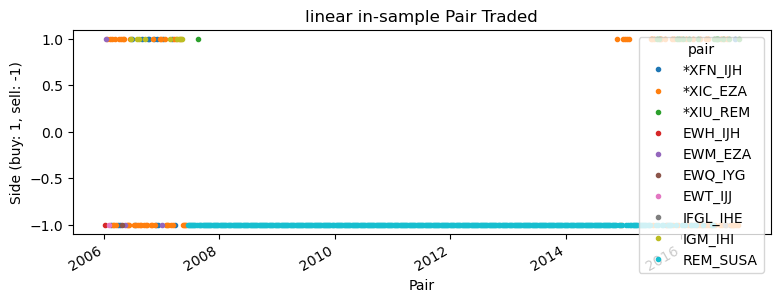

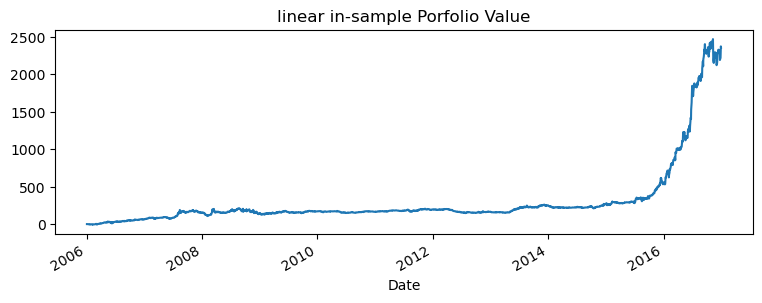

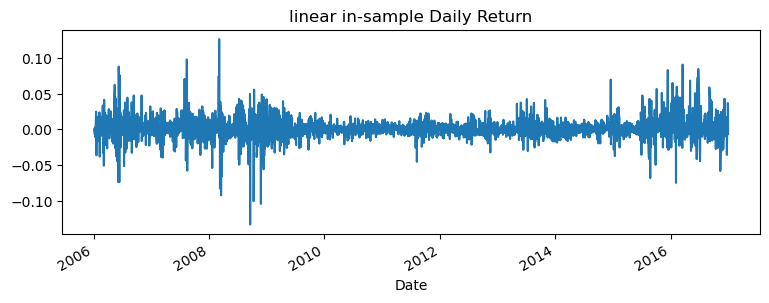

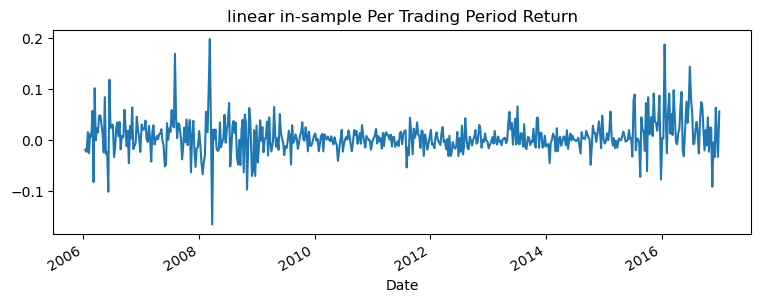

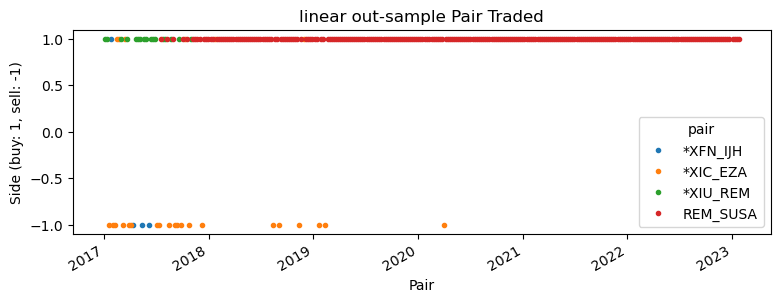

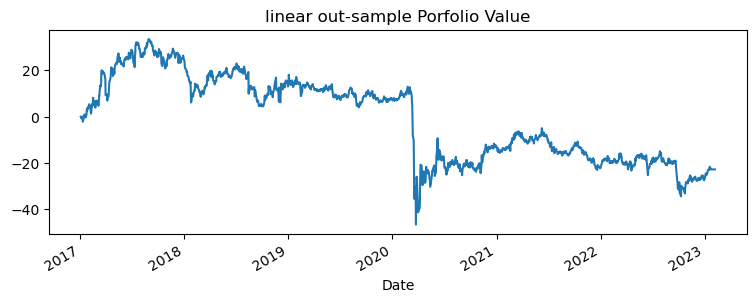

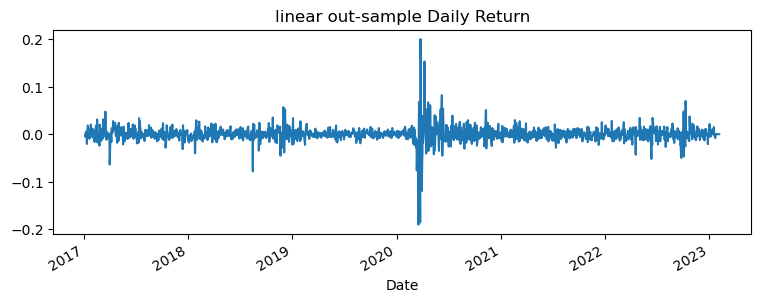

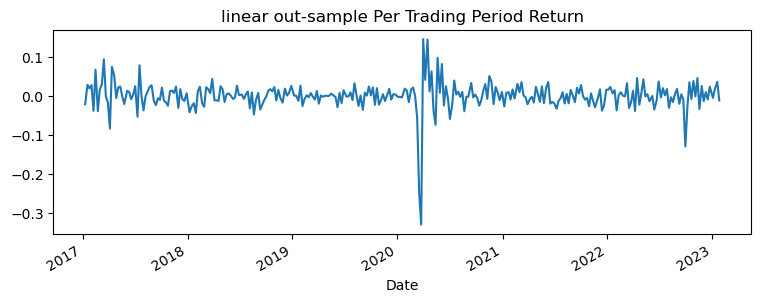

In [149]:
pipeline.run('linear', params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

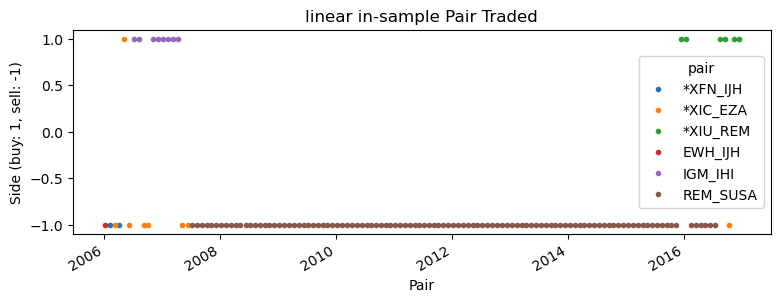

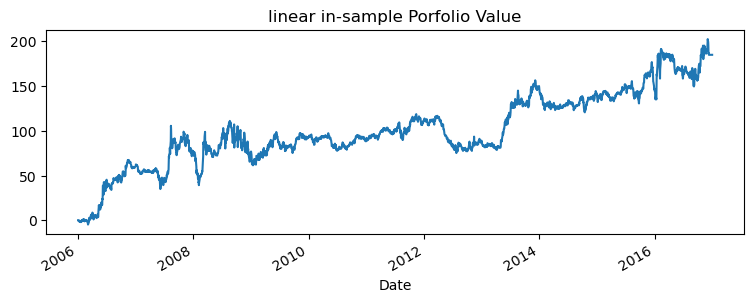

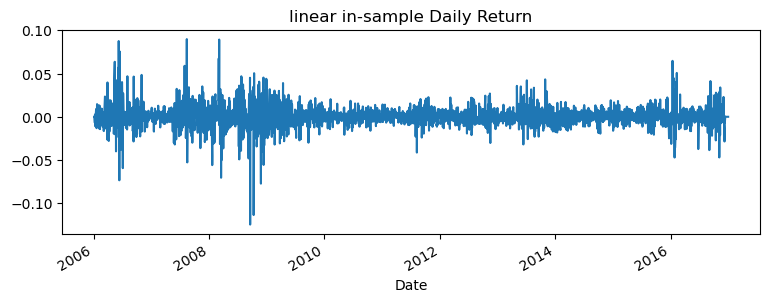

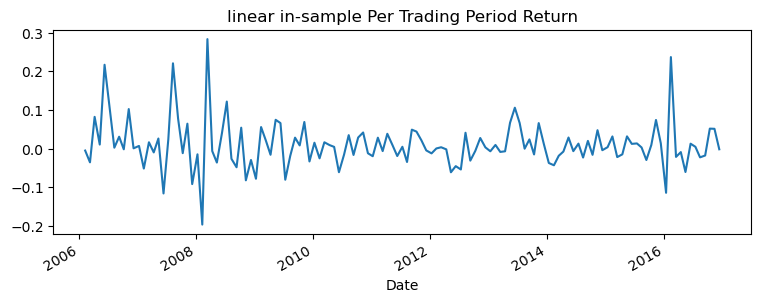

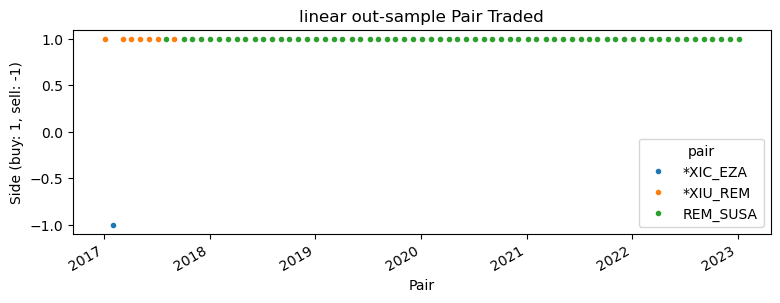

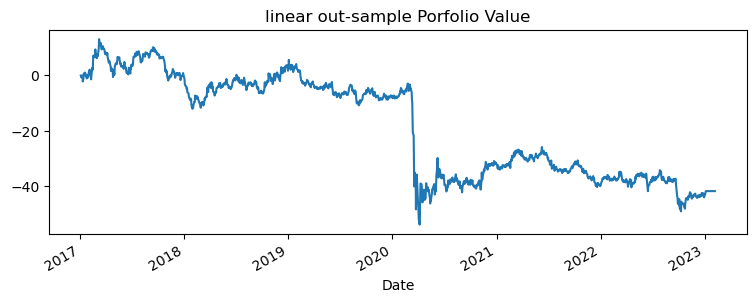

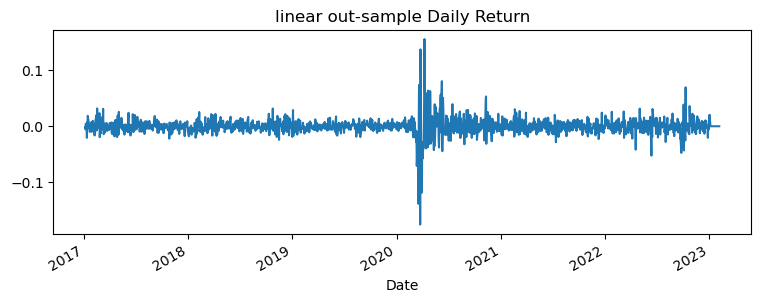

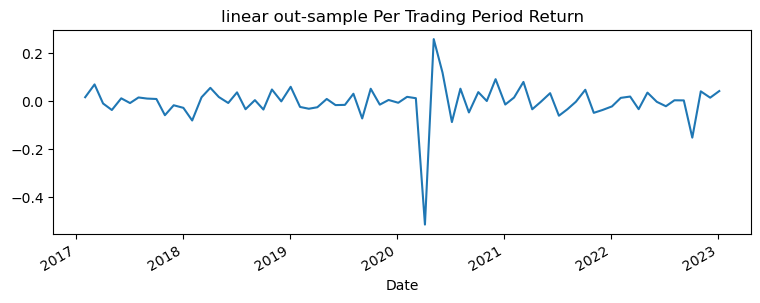

In [150]:
pipeline.run('linear', params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

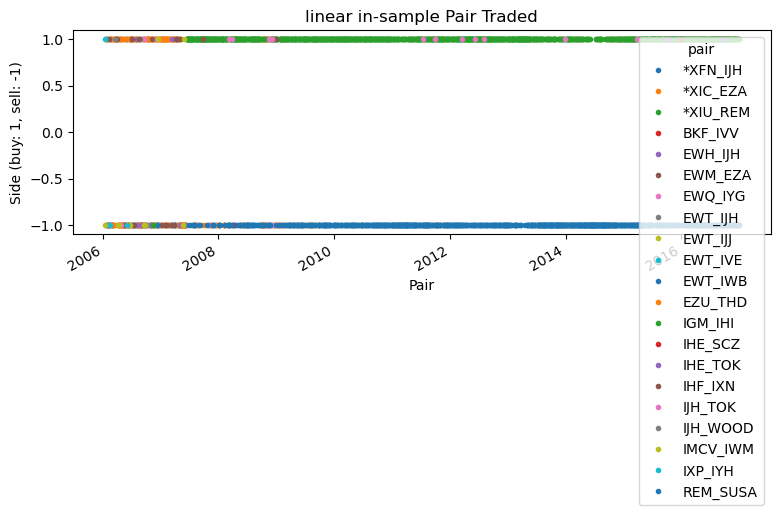

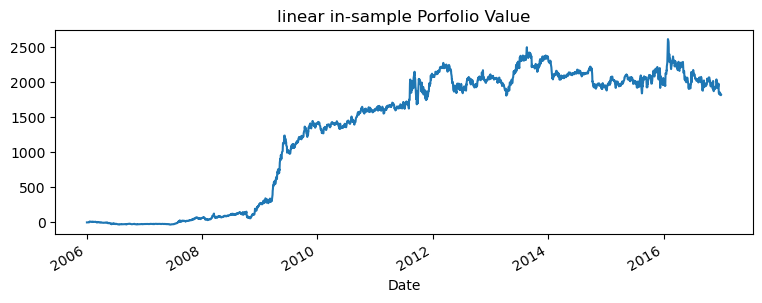

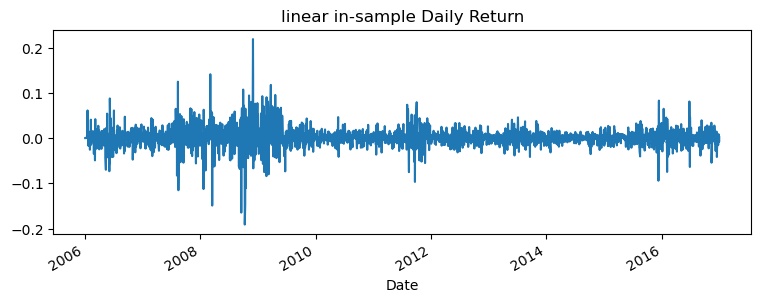

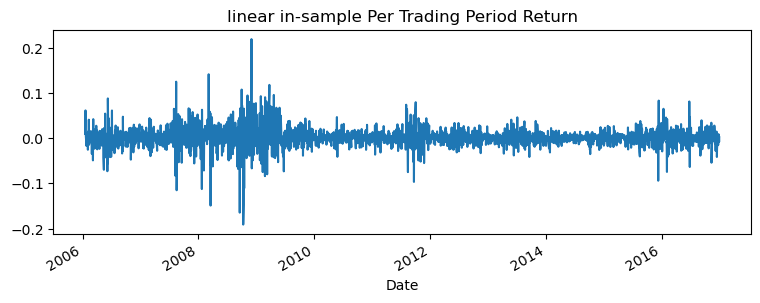

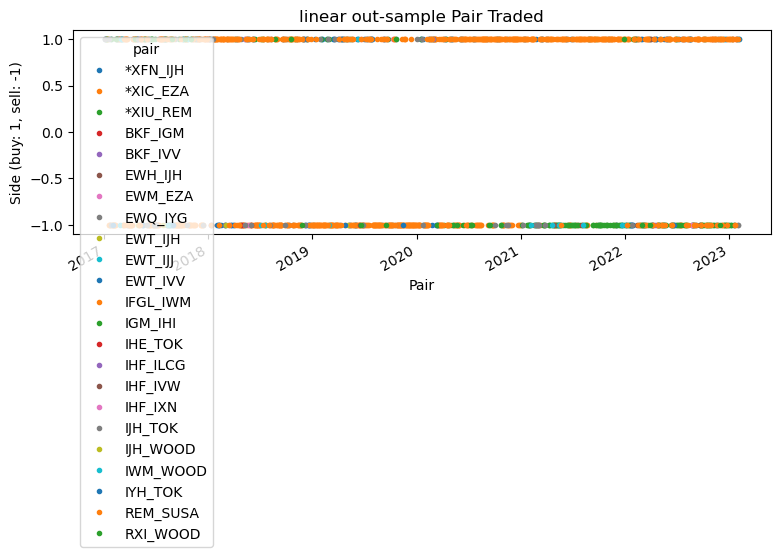

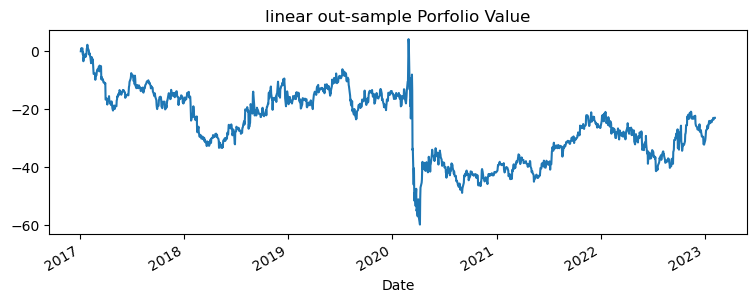

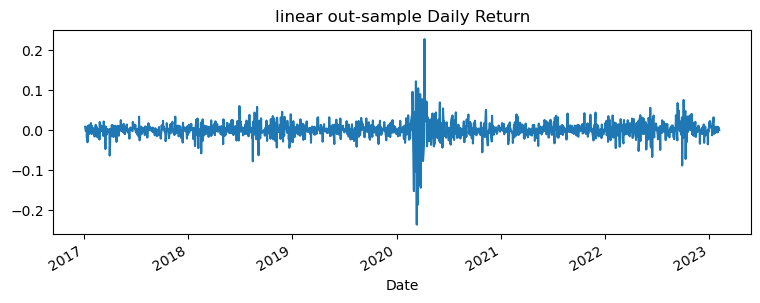

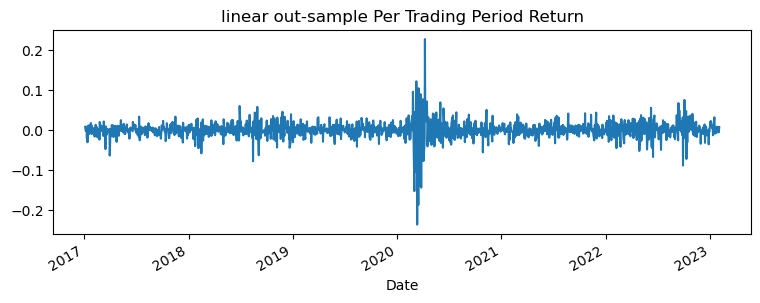

In [151]:
pipeline.run('linear', periodic=True, params = {
                'pred_period': 'D',
                'cost' : 100,
                'holding_period': 1,
            })

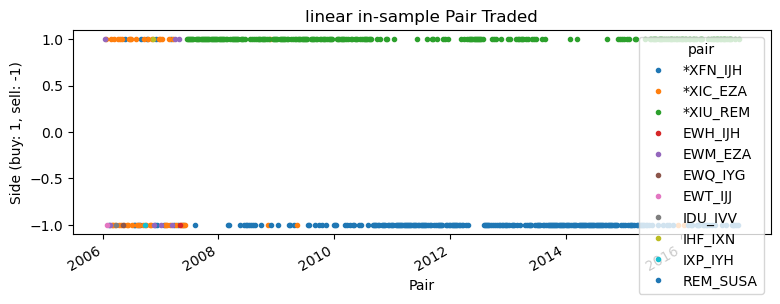

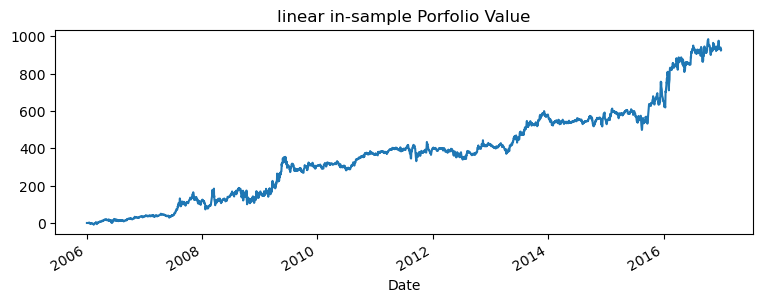

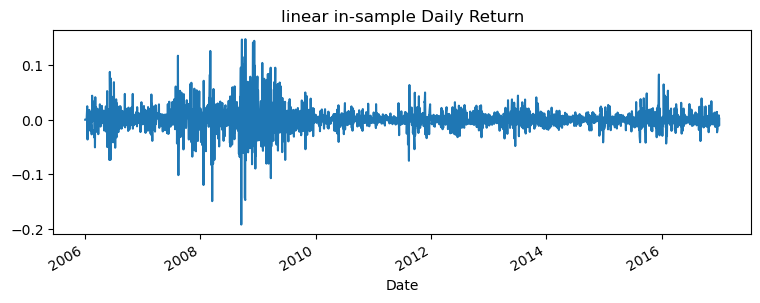

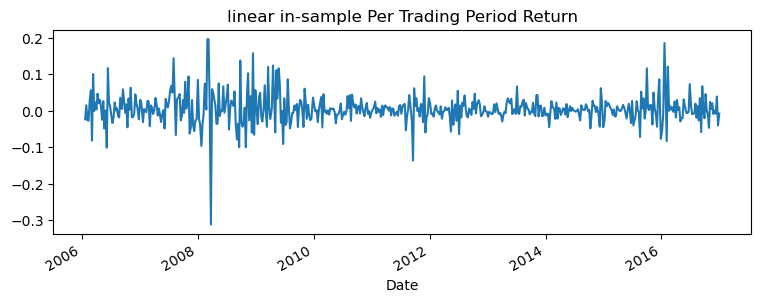

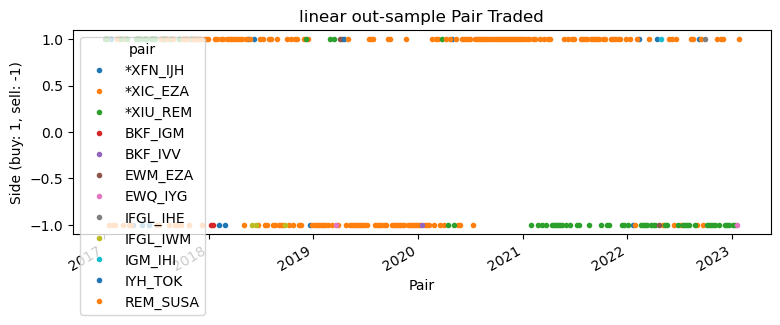

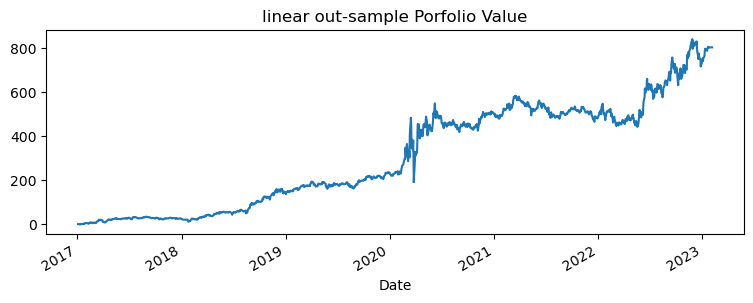

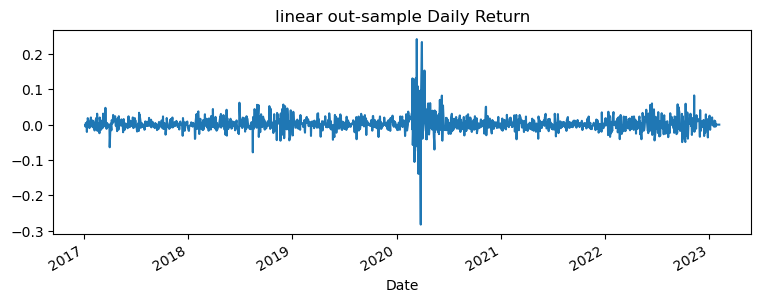

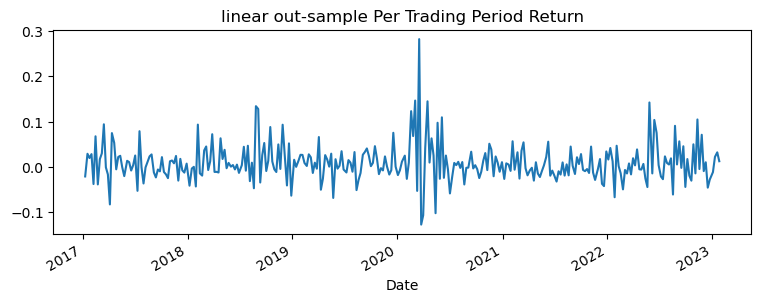

In [152]:
pipeline.run('linear', periodic=True, params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

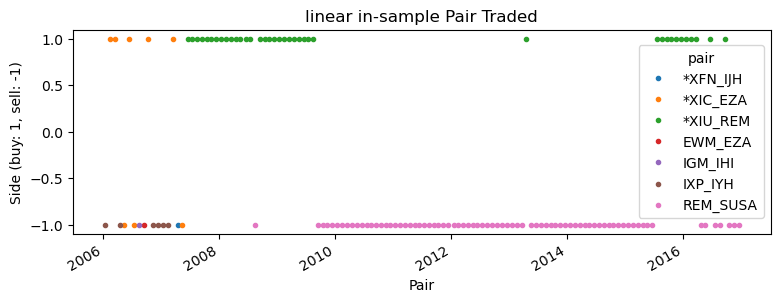

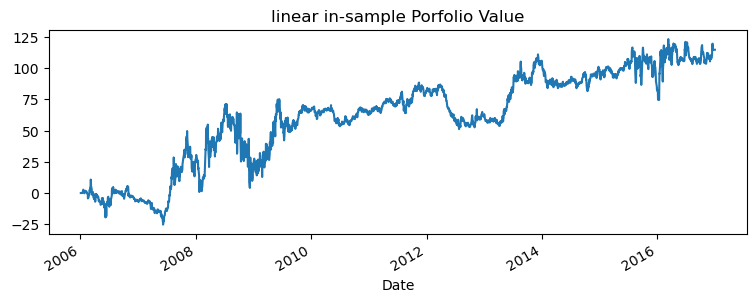

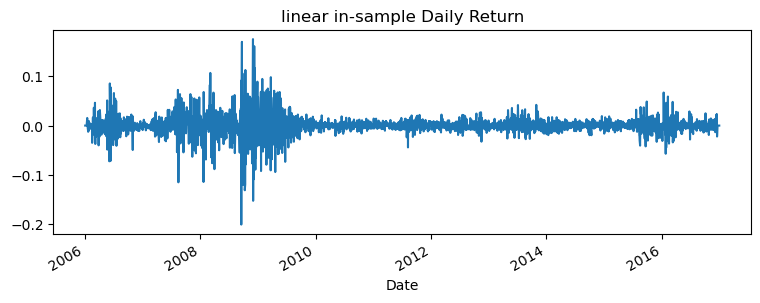

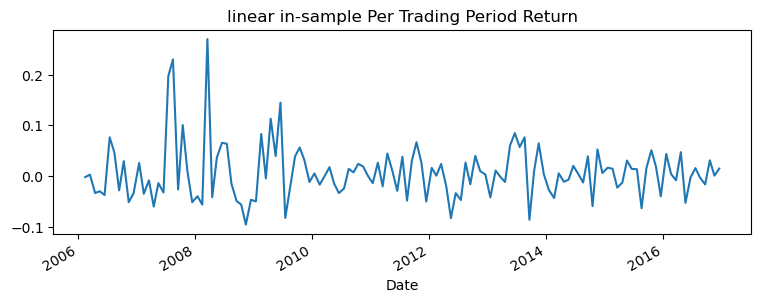

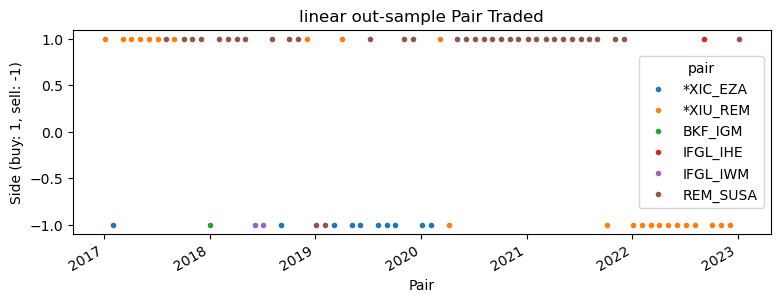

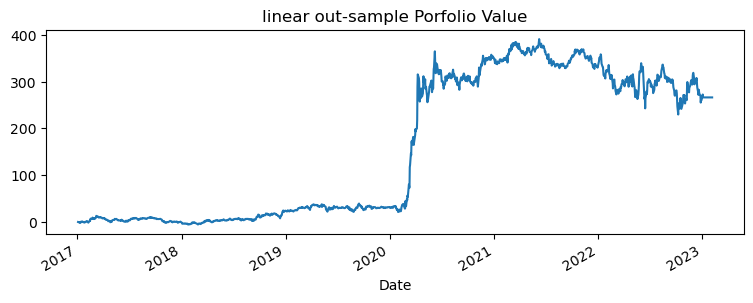

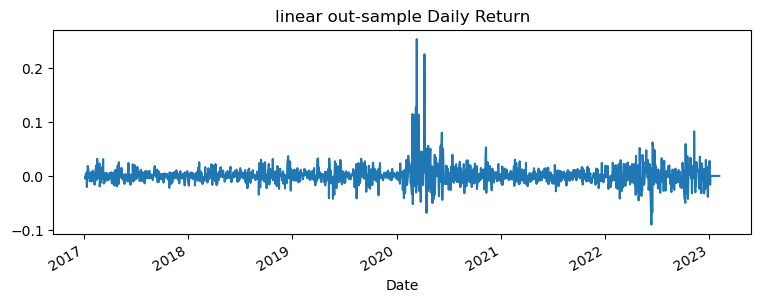

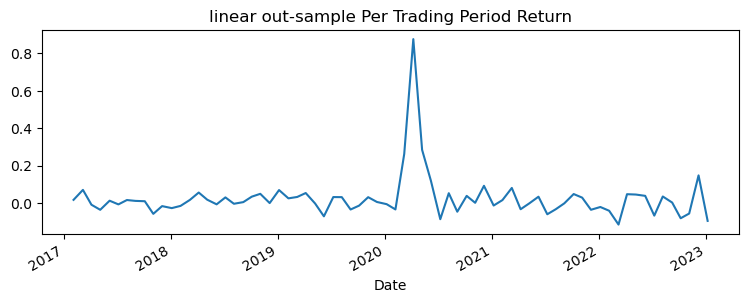

In [153]:
pipeline.run('linear', periodic=True, params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

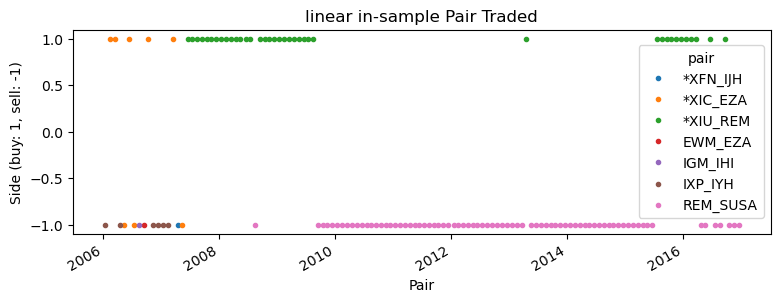

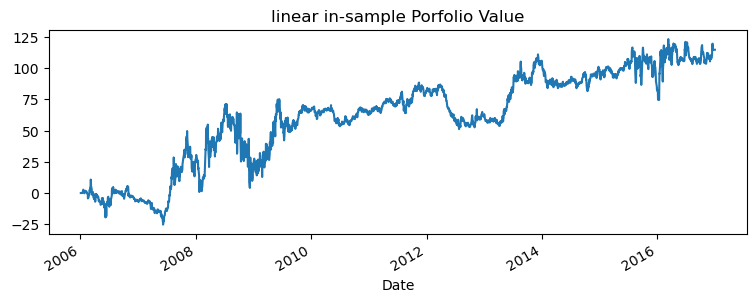

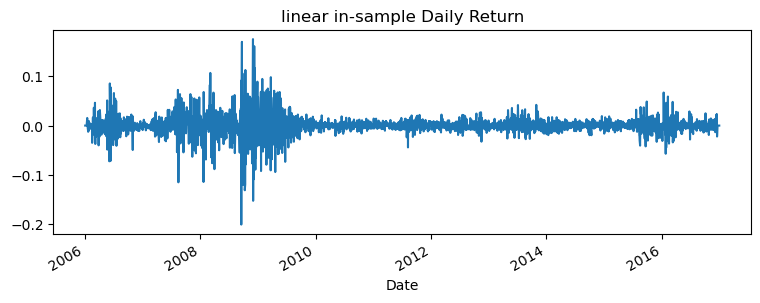

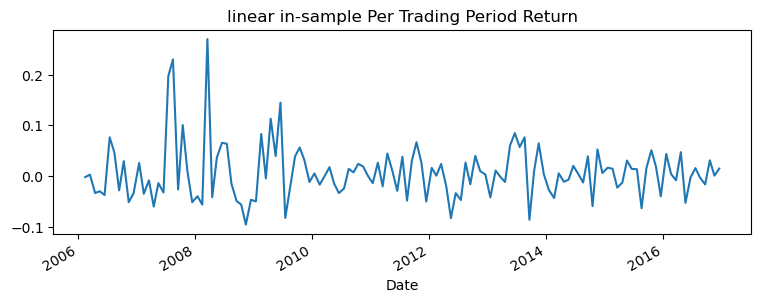

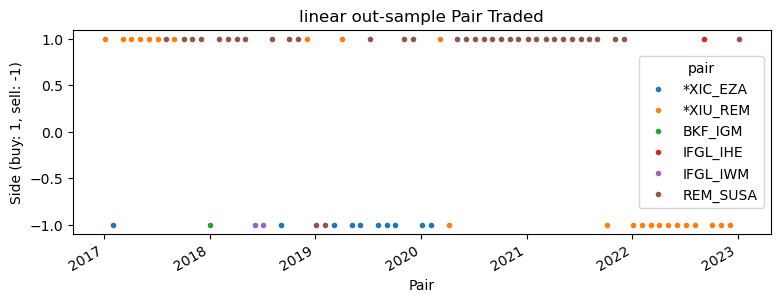

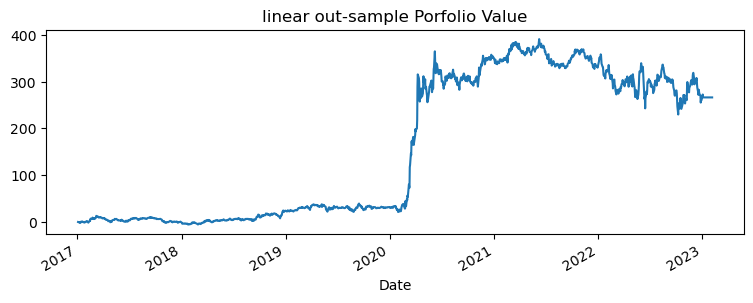

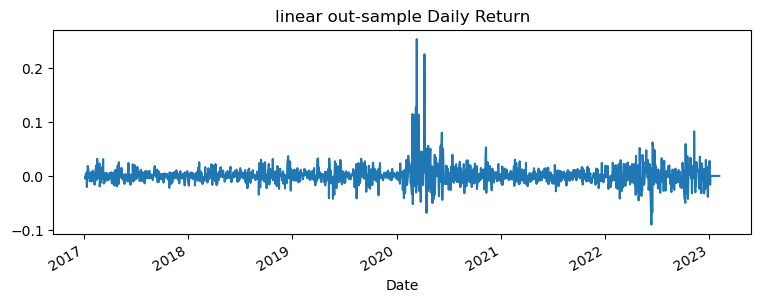

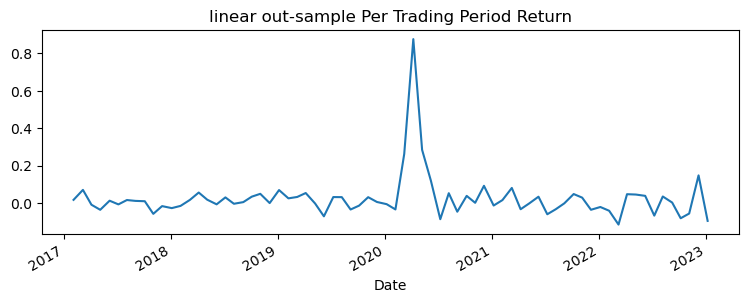

In [154]:
pipeline.run('linear', periodic=True, params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

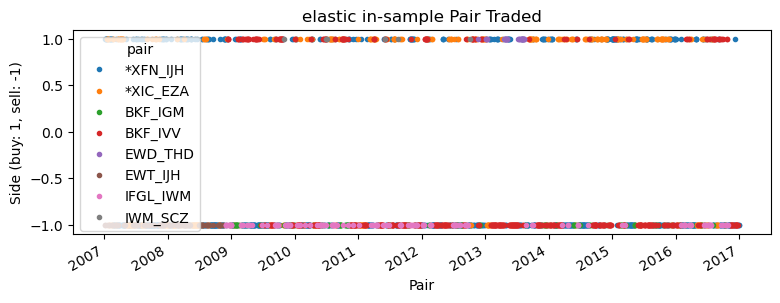

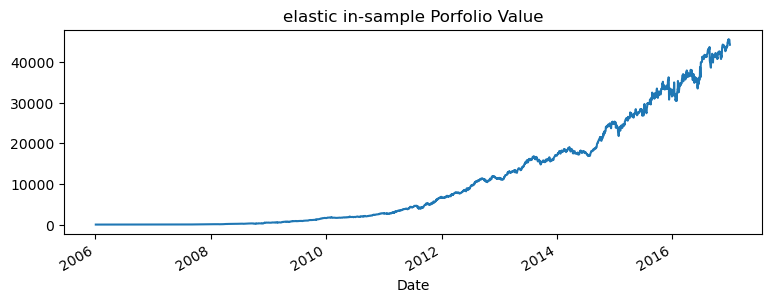

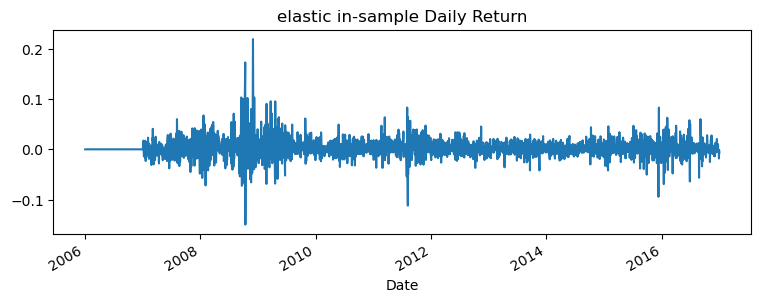

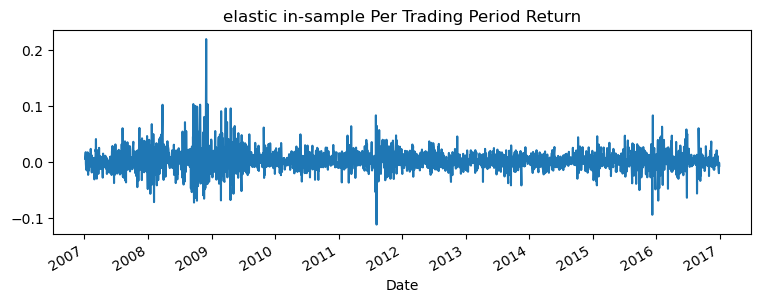

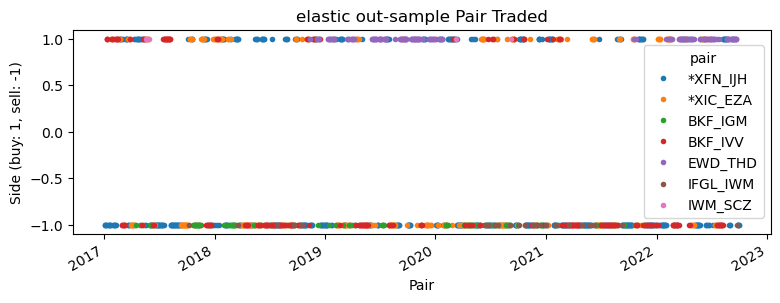

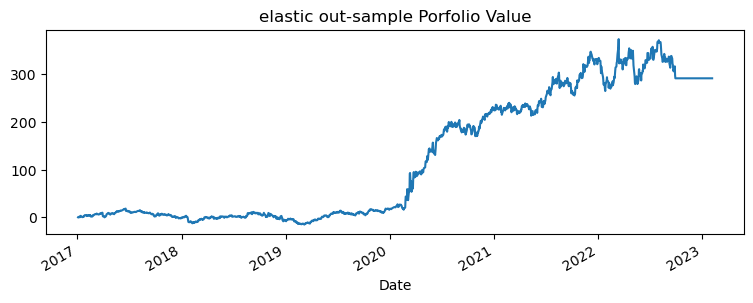

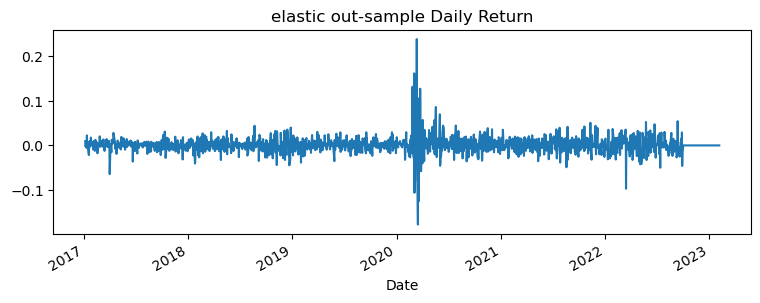

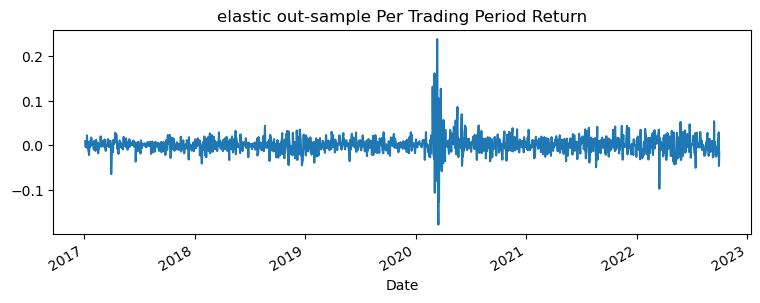

In [155]:
pipeline.run('elastic', params = {
                'pred_period': 'D',
                'cost' : 100,
                'holding_period': 1,
            })

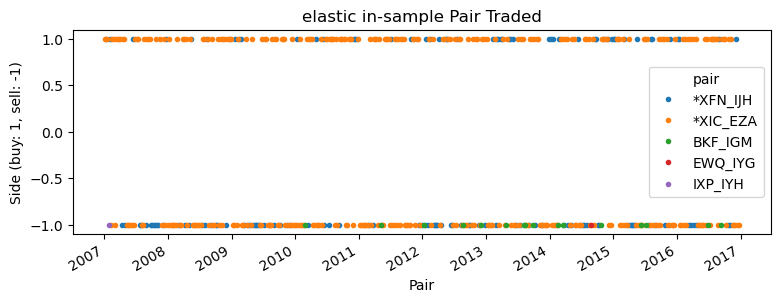

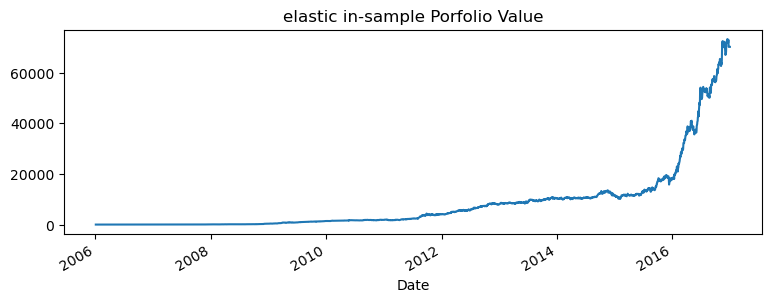

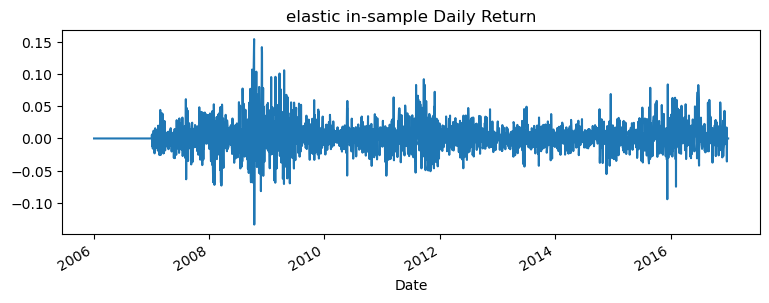

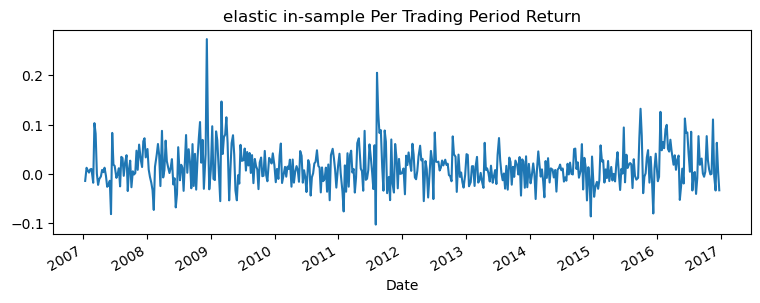

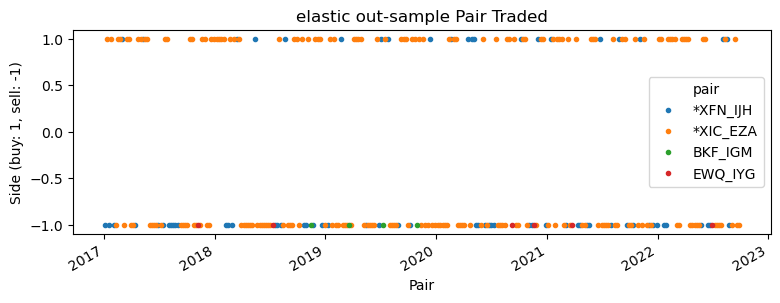

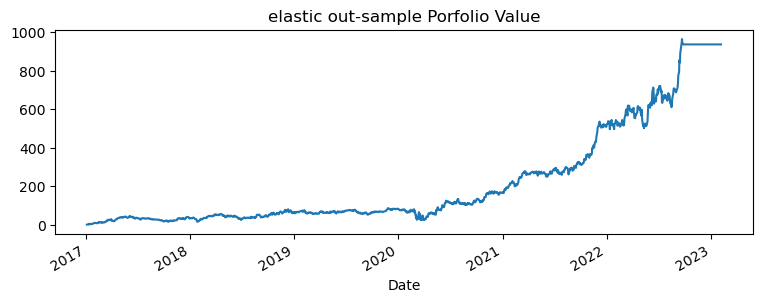

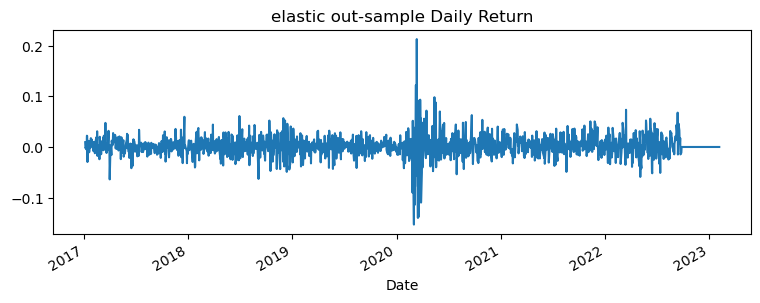

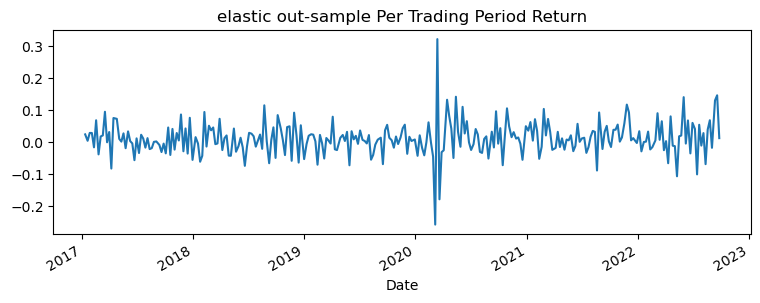

In [156]:
pipeline.run('elastic', params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

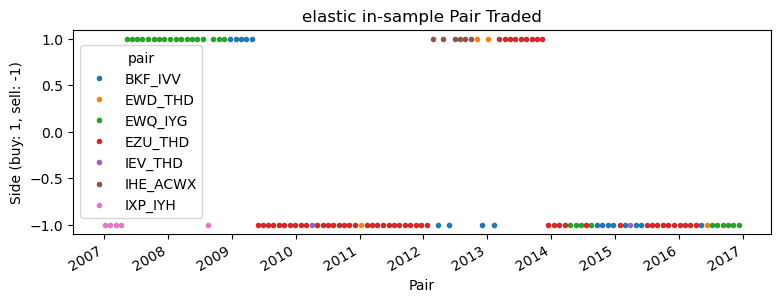

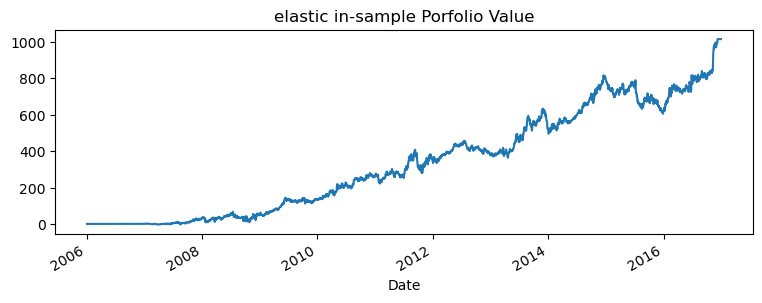

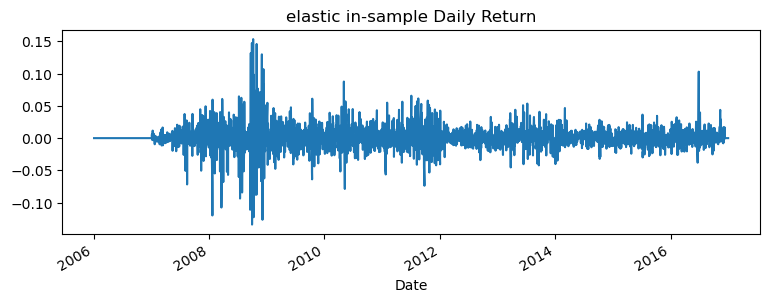

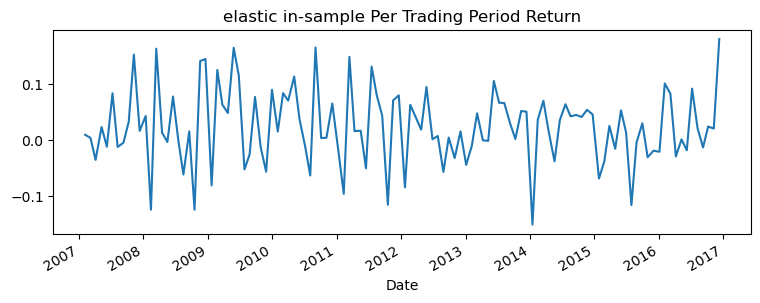

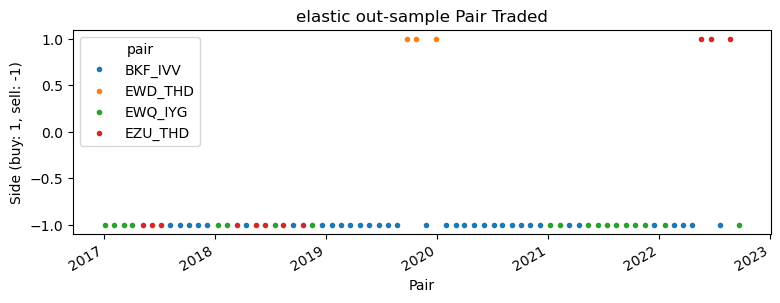

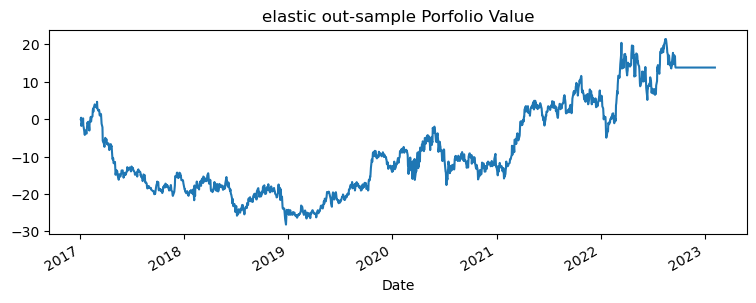

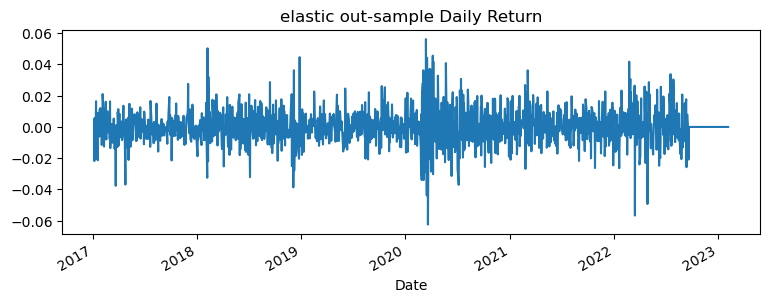

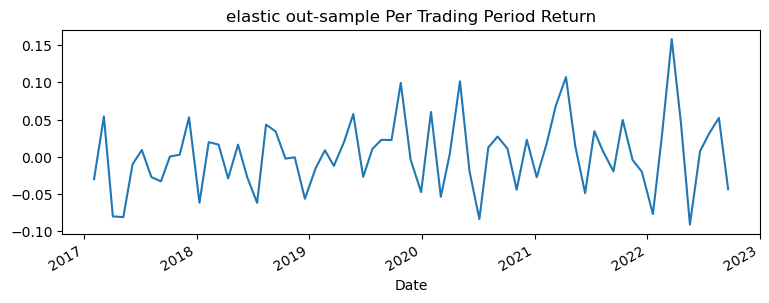

In [157]:
pipeline.run('elastic', params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

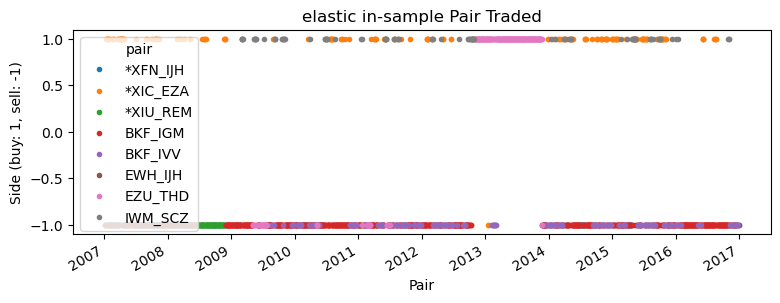

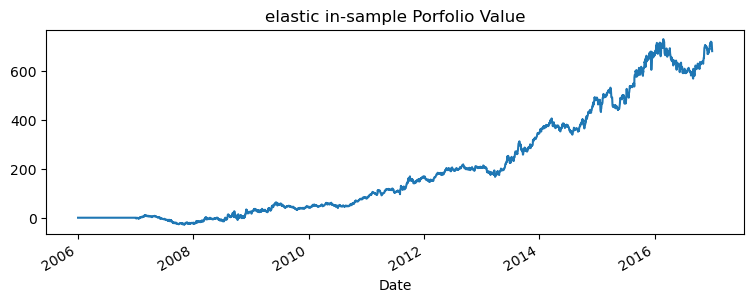

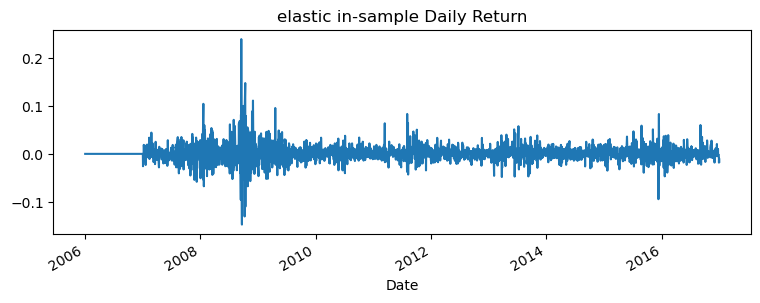

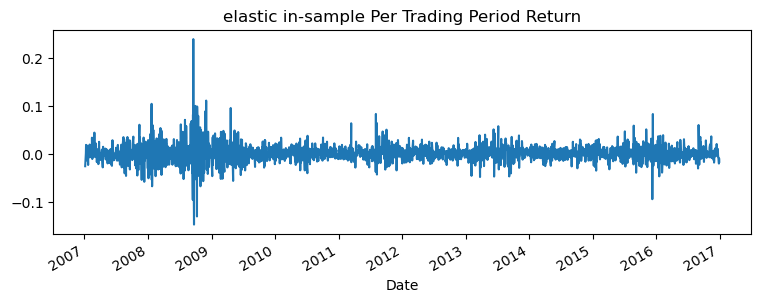

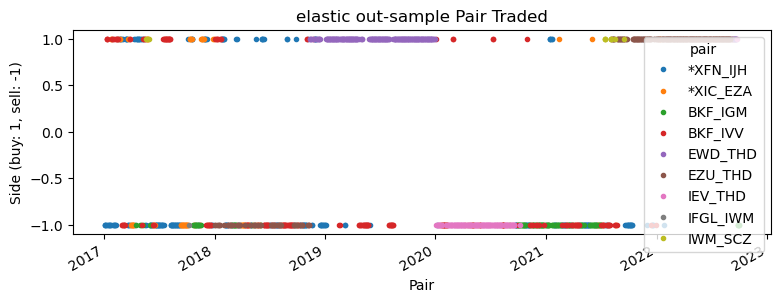

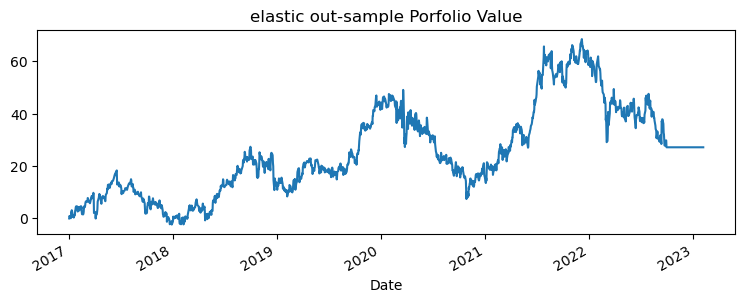

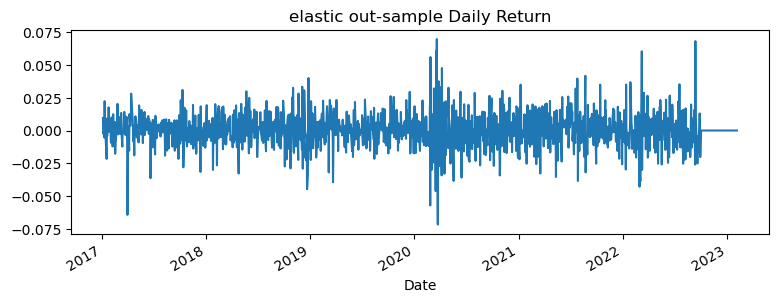

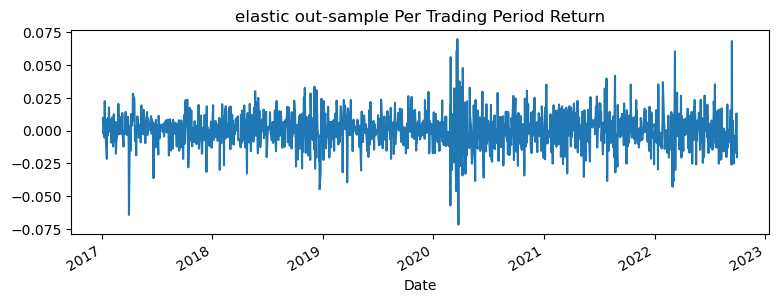

In [158]:
p_df = pipeline.run('elastic', periodic=True, params = {
                'pred_period': 'D',
                'cost' : 100.,
                'holding_period': 1,
            })

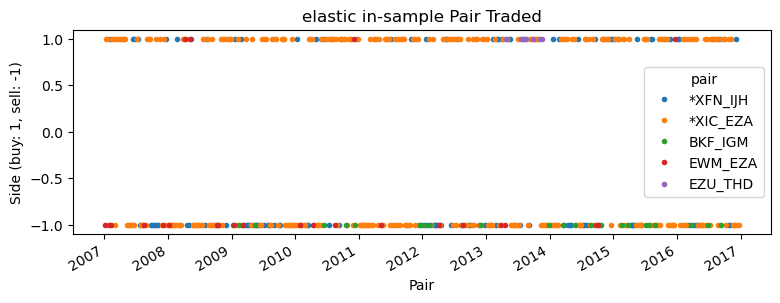

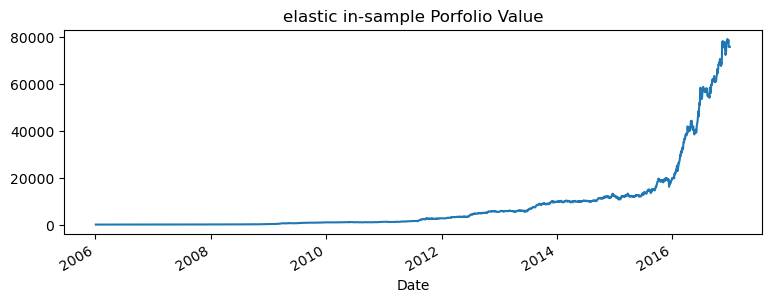

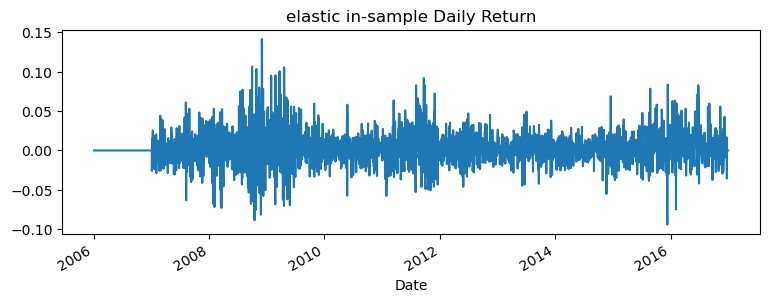

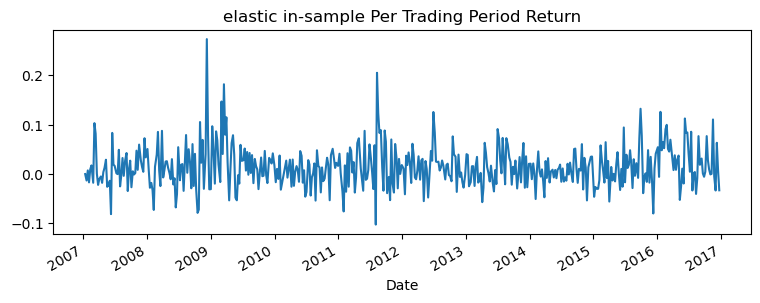

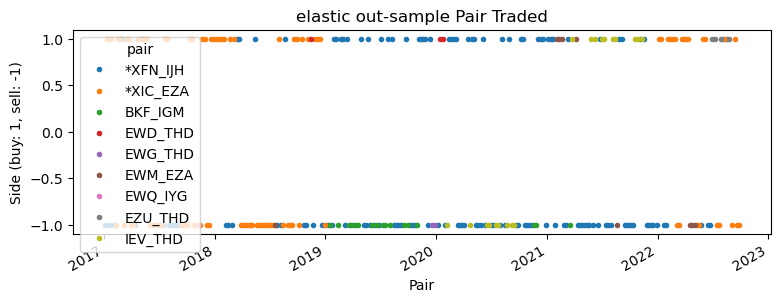

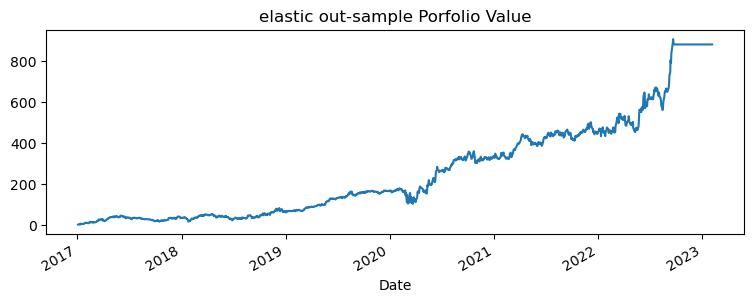

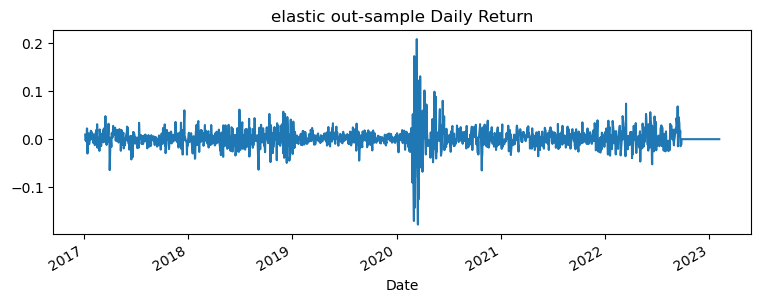

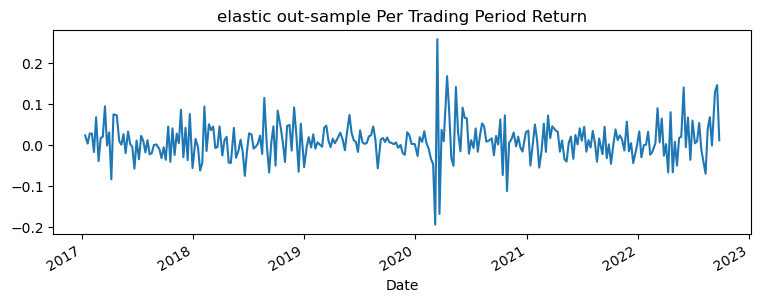

In [159]:
pipeline.run('elastic', periodic=True, params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

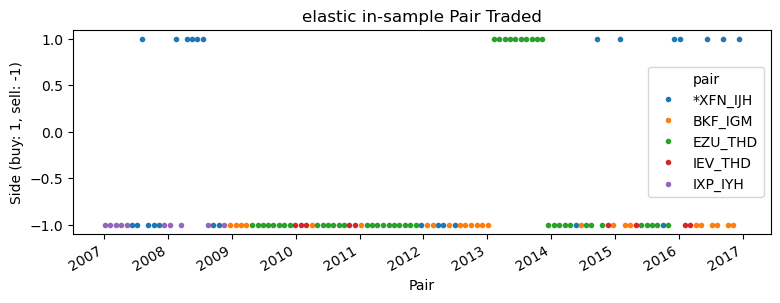

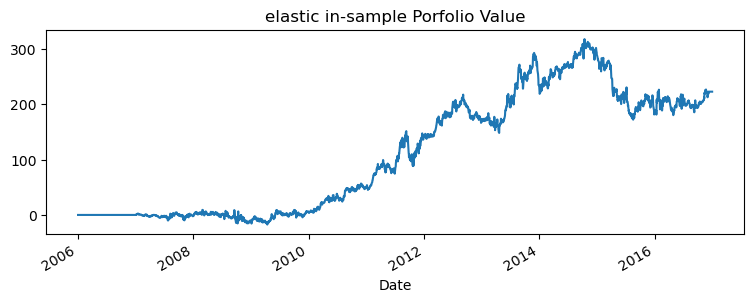

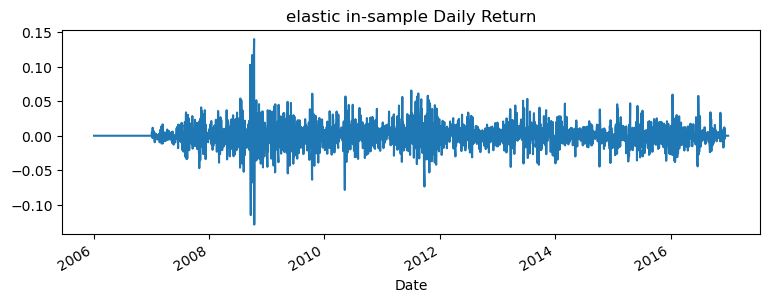

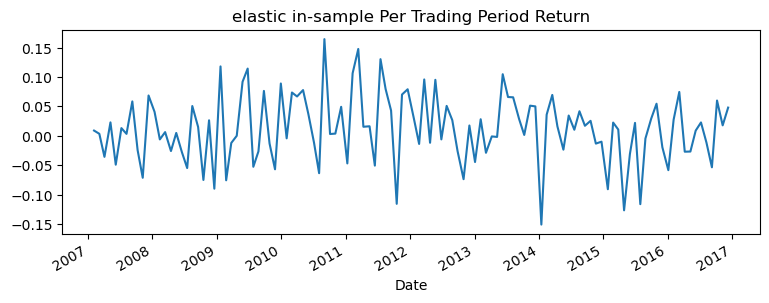

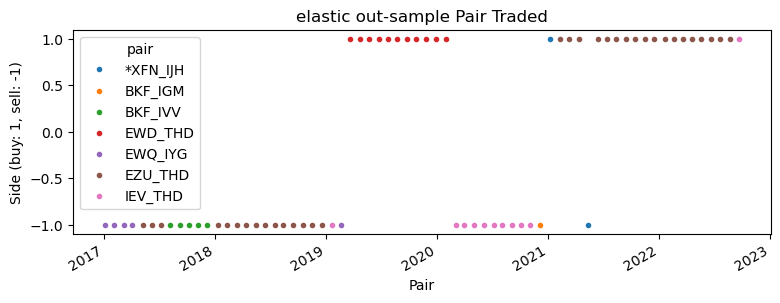

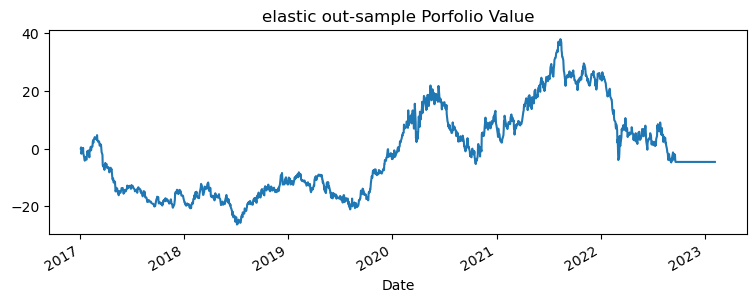

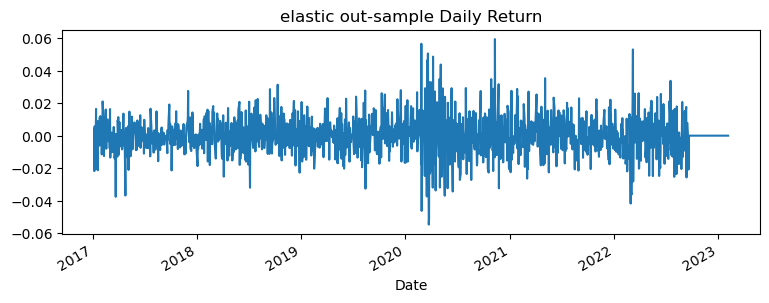

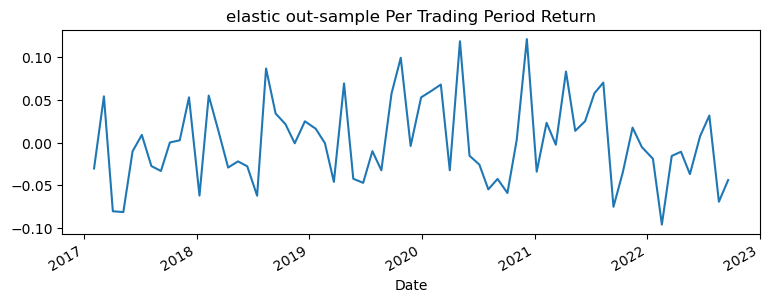

In [160]:
pipeline.run('elastic', periodic=True, params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

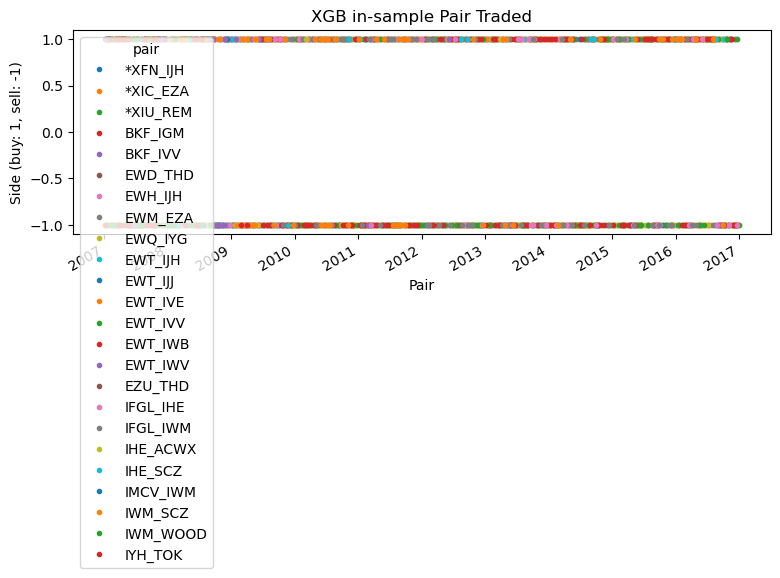

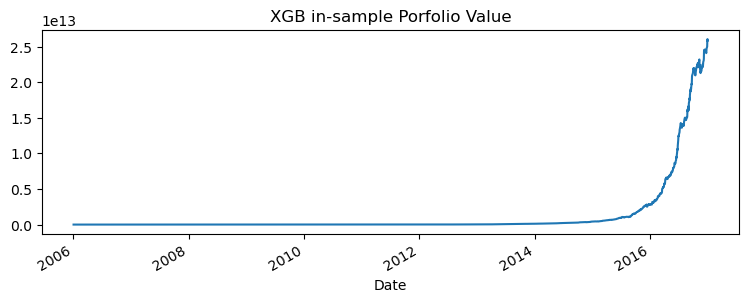

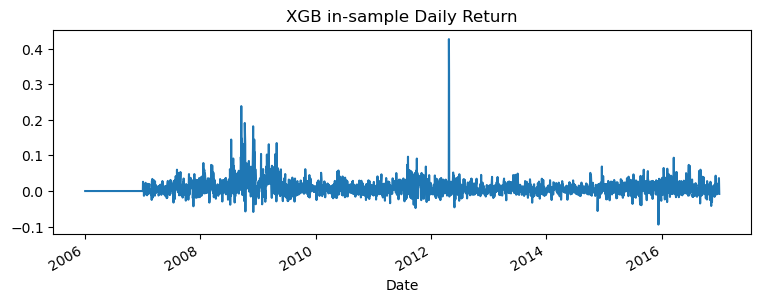

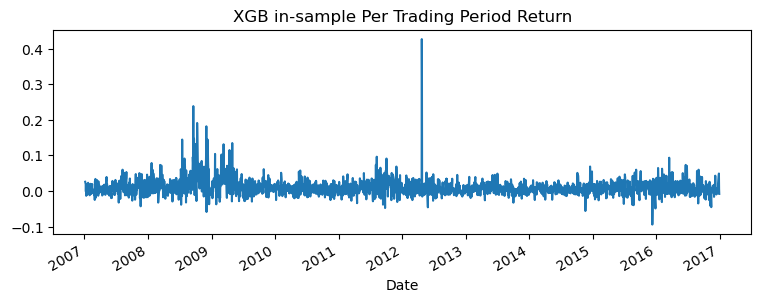

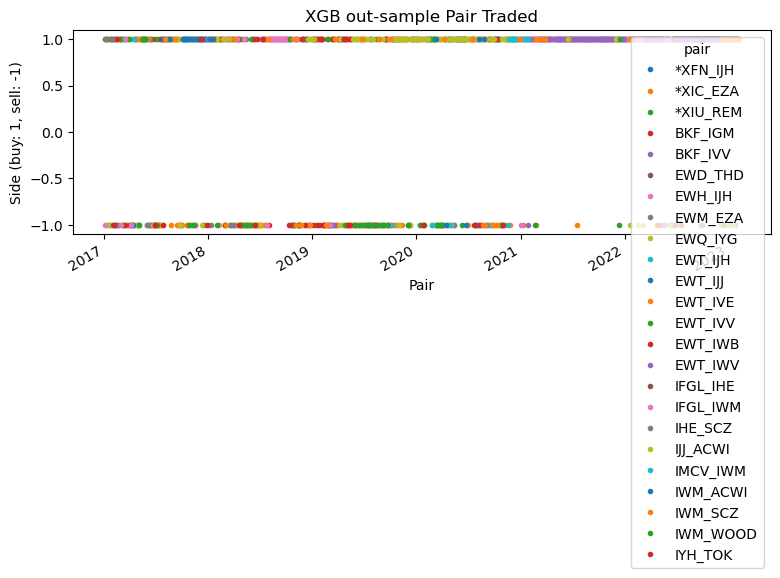

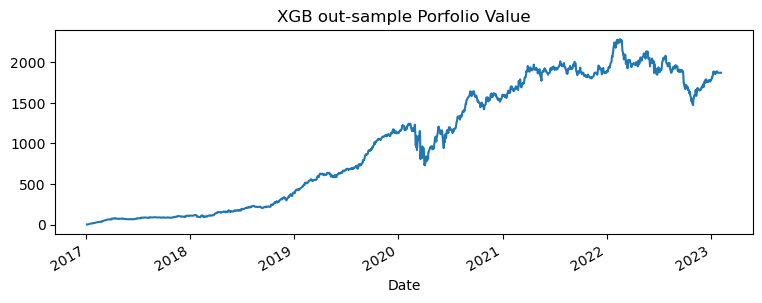

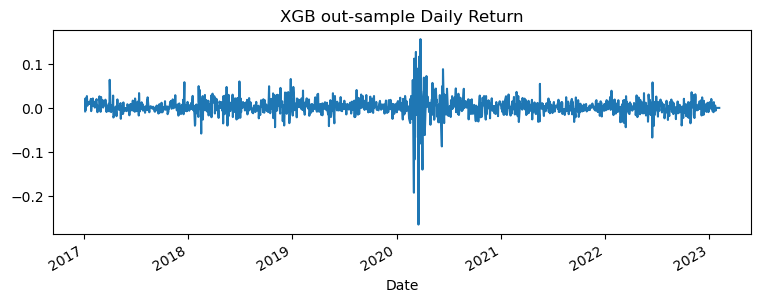

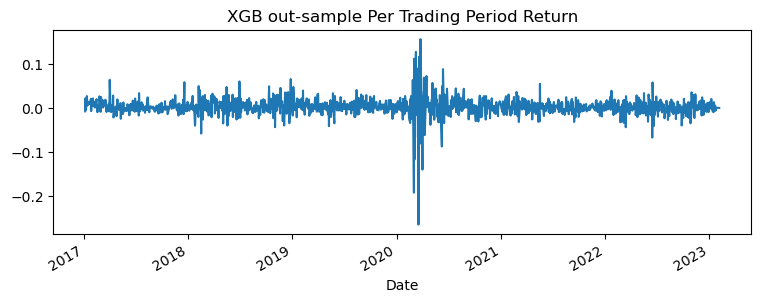

In [161]:
pipeline.run('XGB', params = {
                'pred_period': 'D',
                'cost' : 100,
                'holding_period': 1,
            })

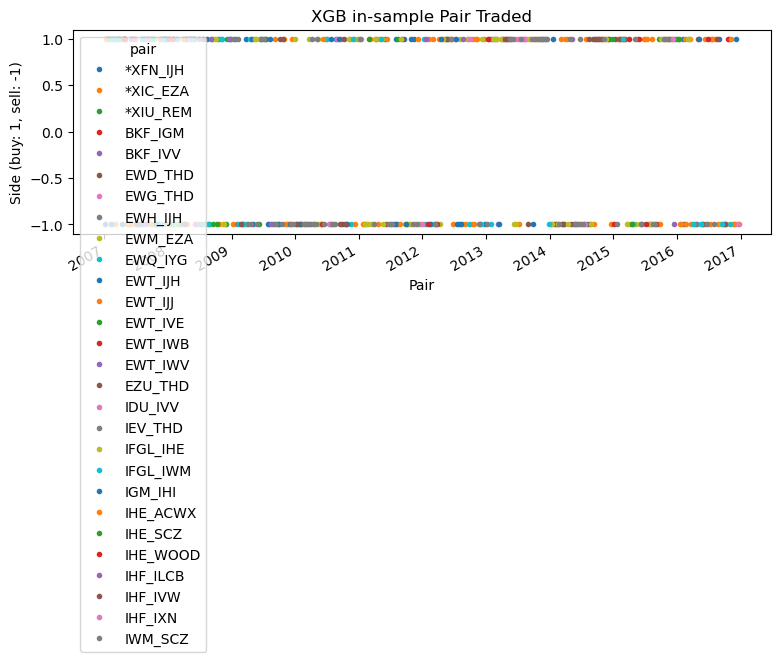

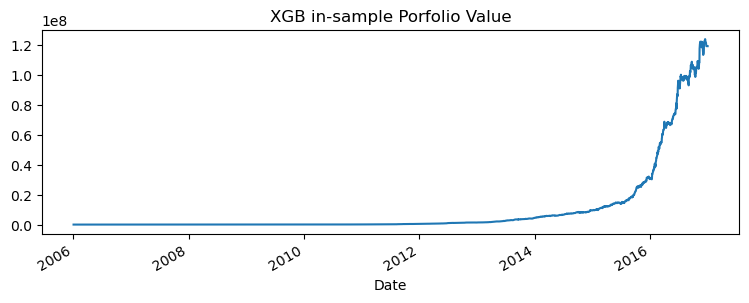

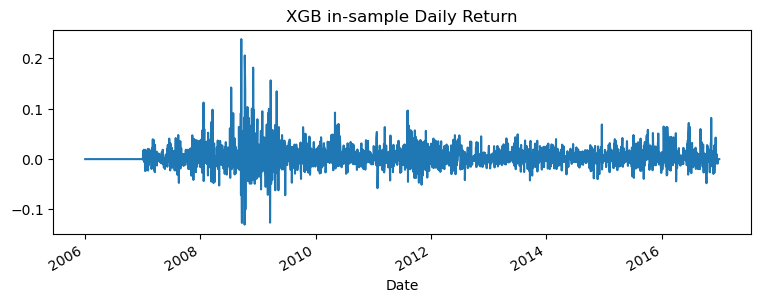

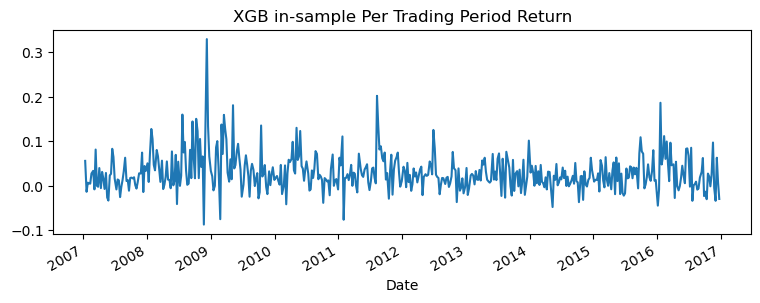

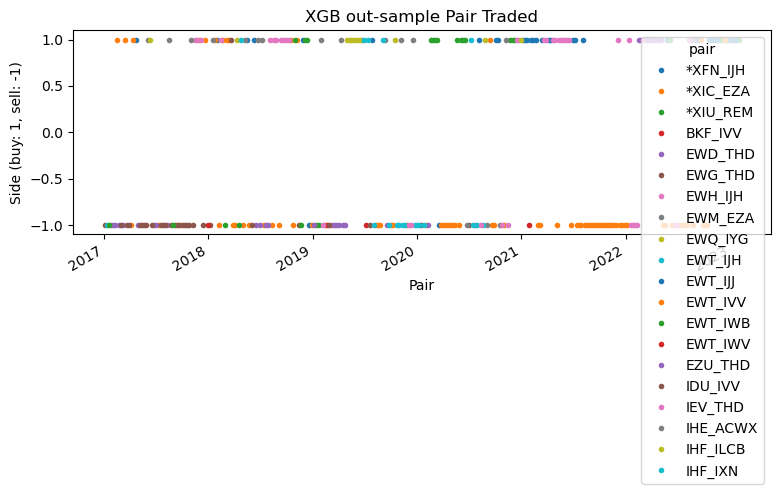

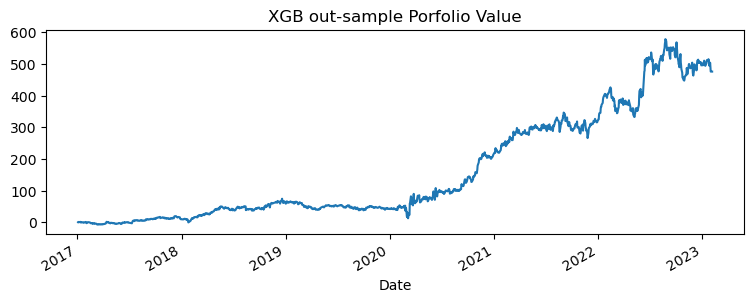

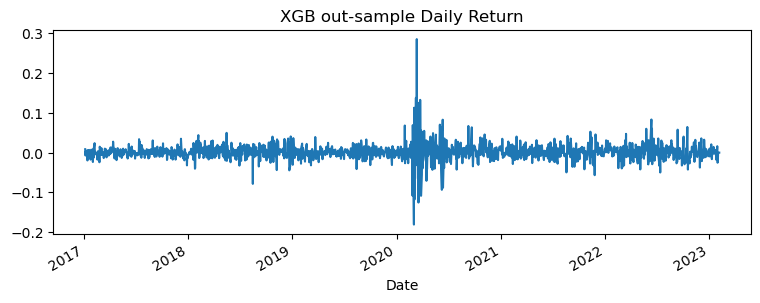

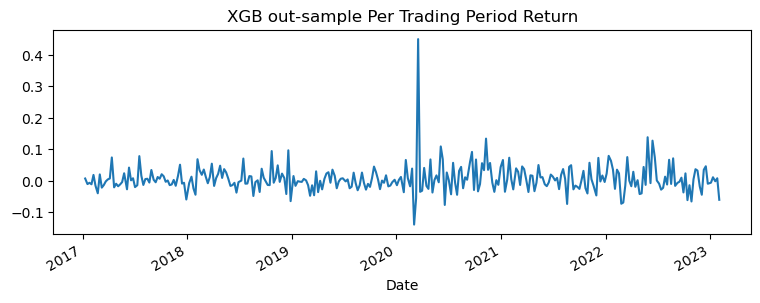

In [162]:
pipeline.run('XGB', params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

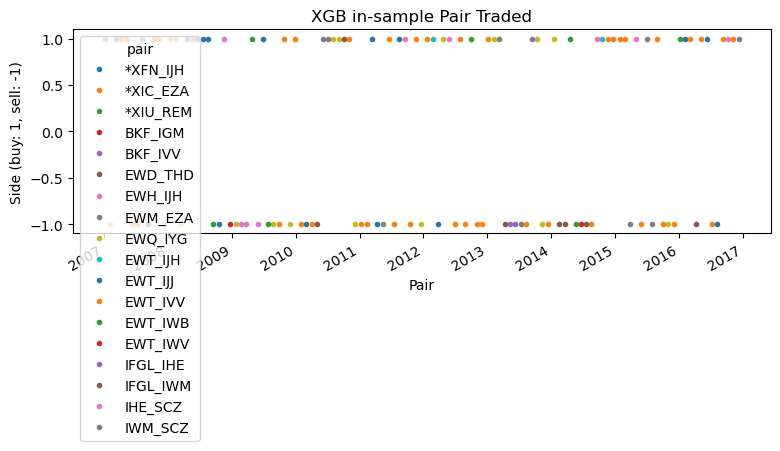

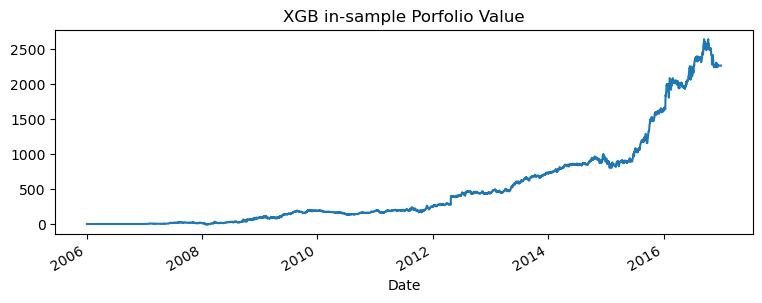

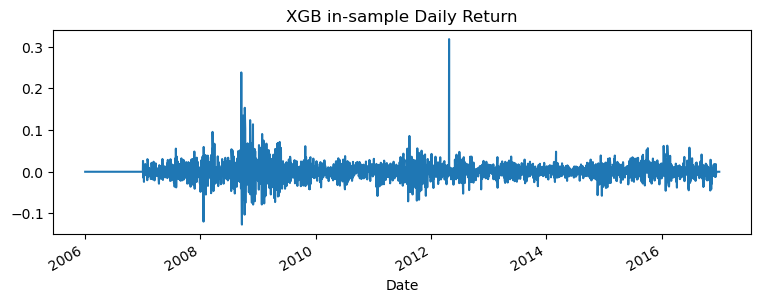

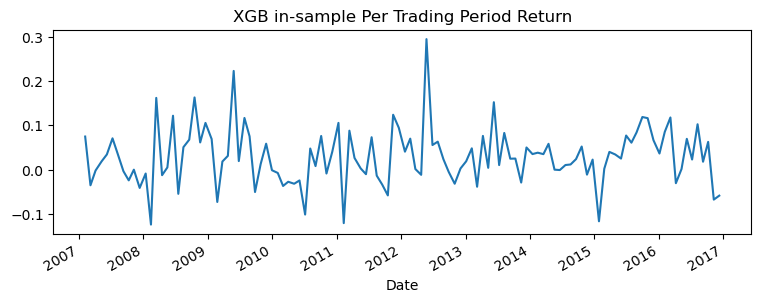

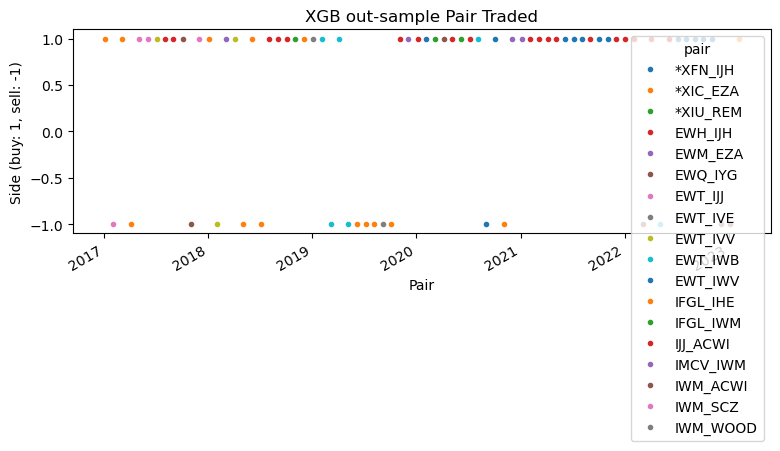

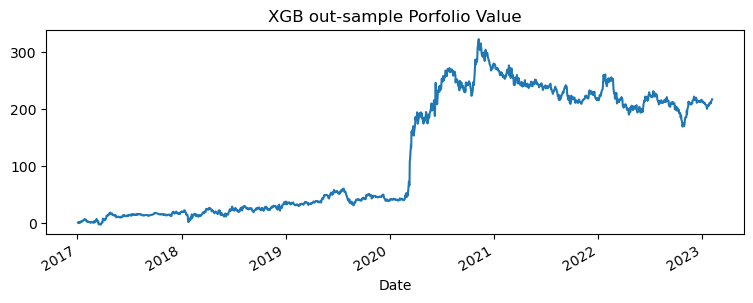

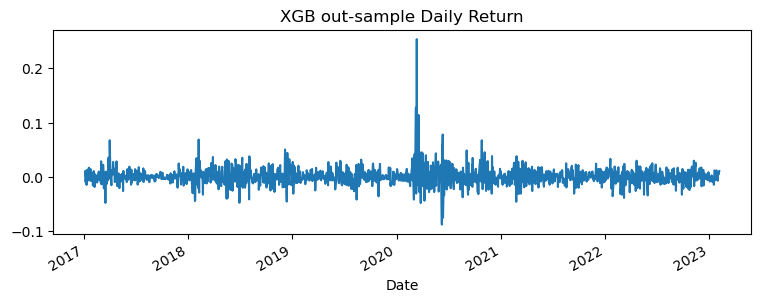

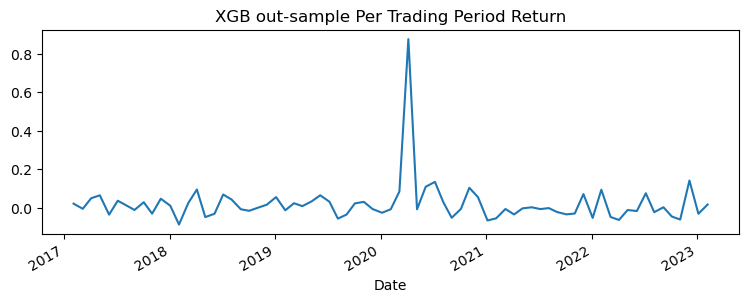

In [163]:
pipeline.run('XGB', params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

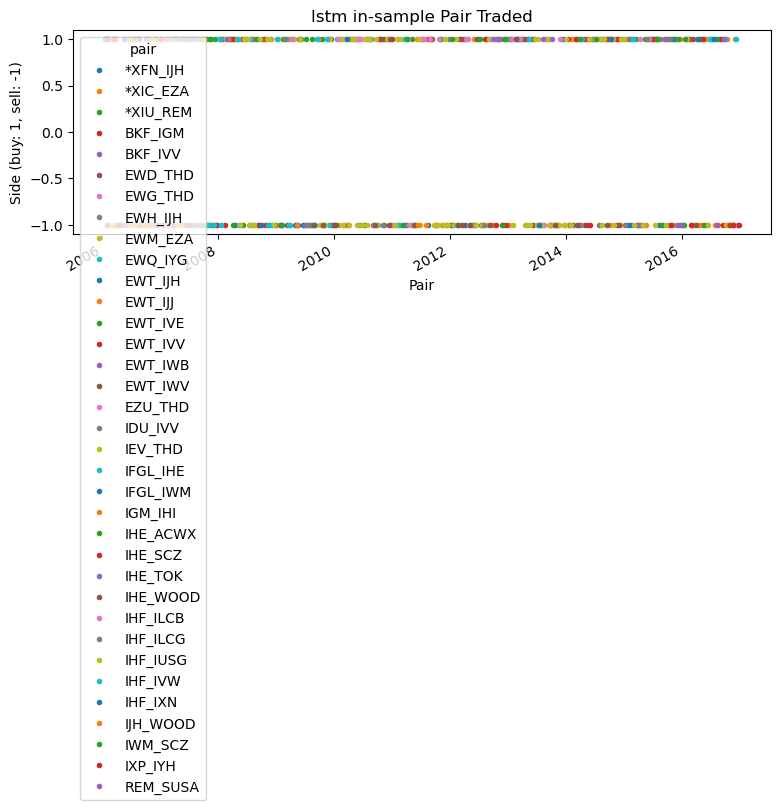

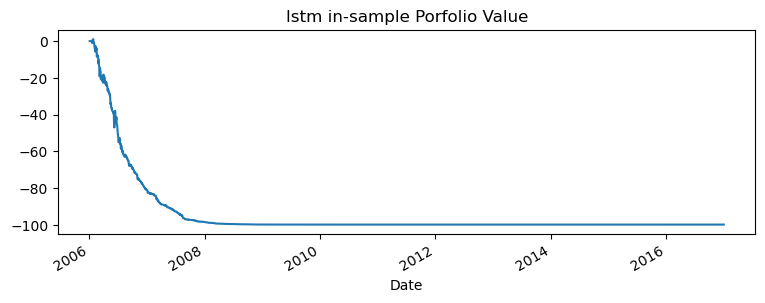

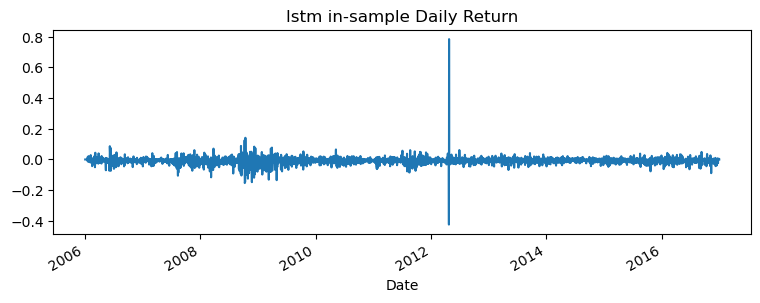

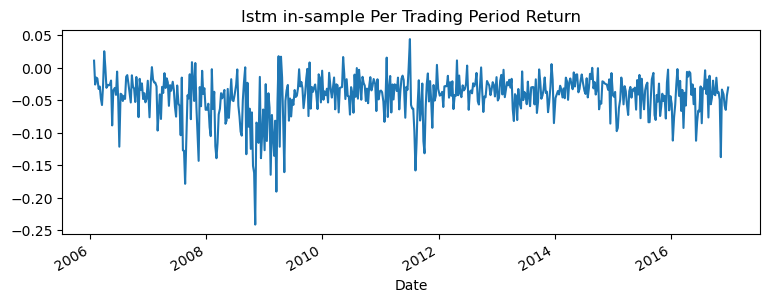

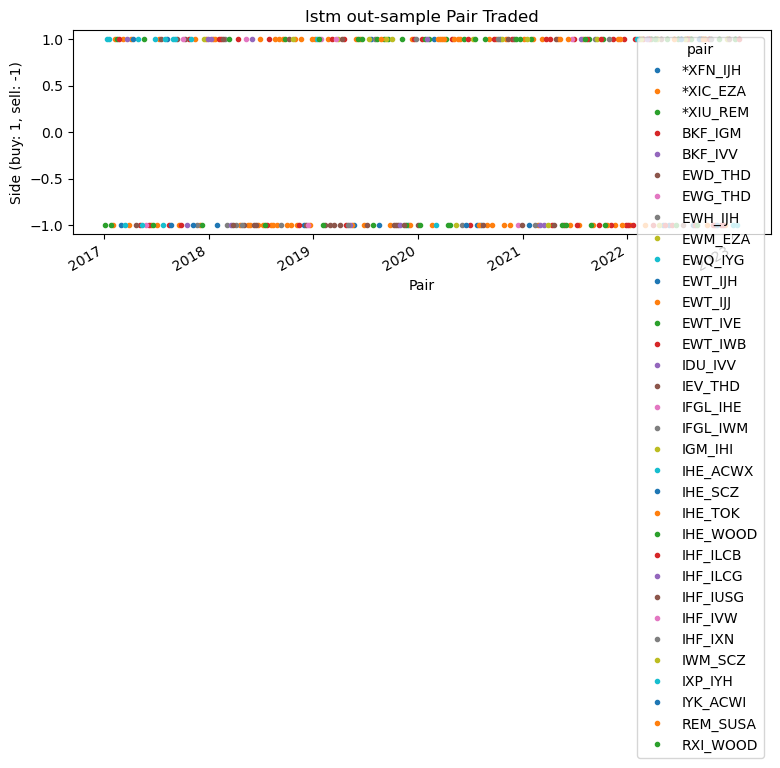

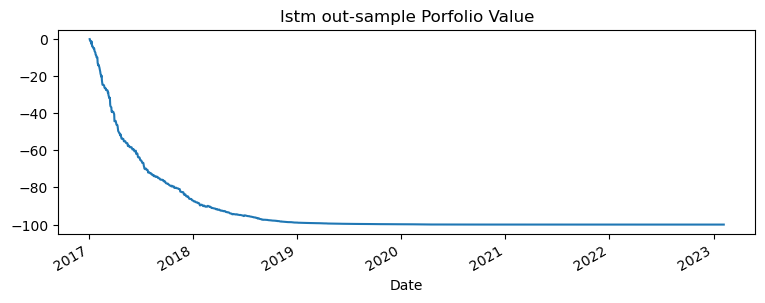

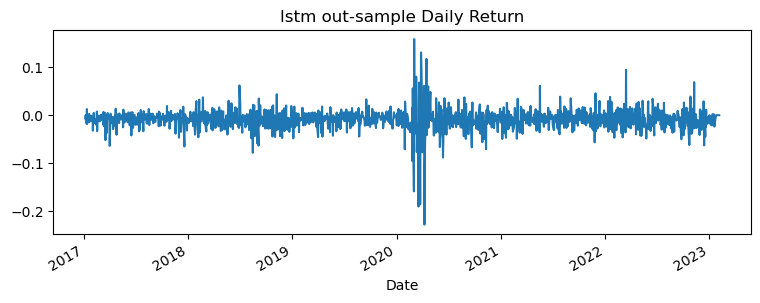

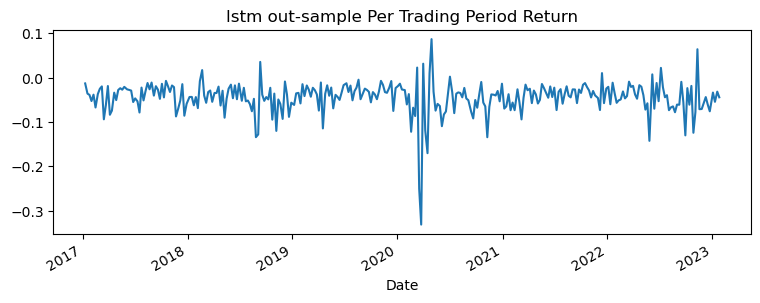

In [164]:
pipeline.run('lstm', params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

In [165]:
pipeline.run('percentile_current', params = {
                'pred_period': 'D',
                'holding_period': 1,
                'distribution_period': 10,
                'training_period':2769,
                'periodic': False,
                'cost': 100
            }, currentMode=True)

ValueError: Shape of passed values is (4294, 1), indices imply (4303, 1)

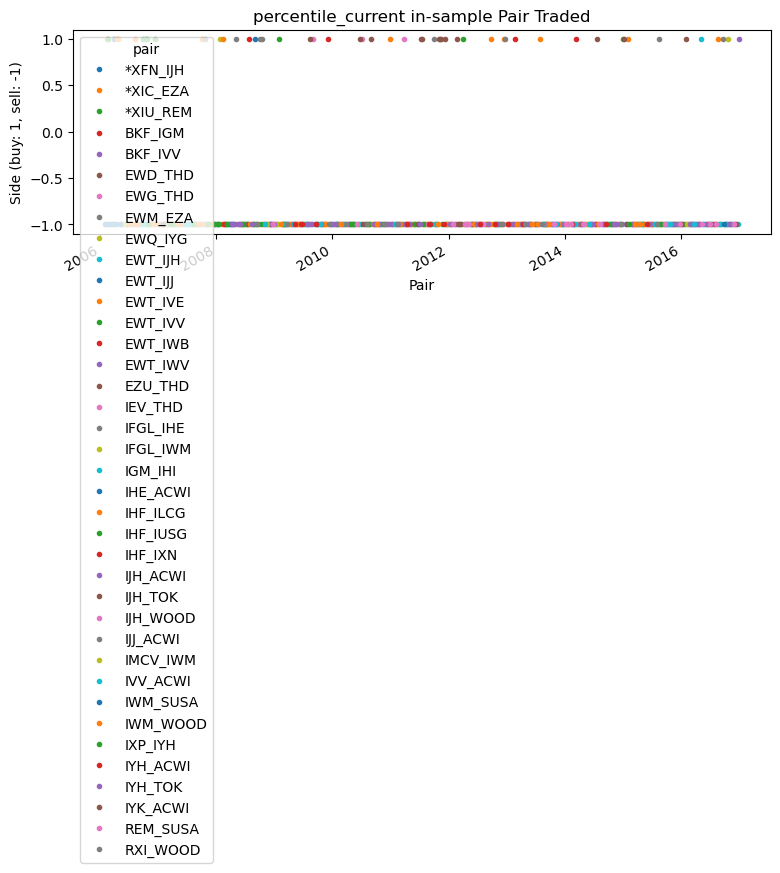

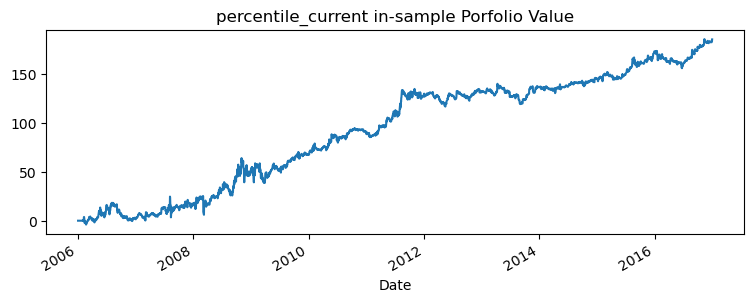

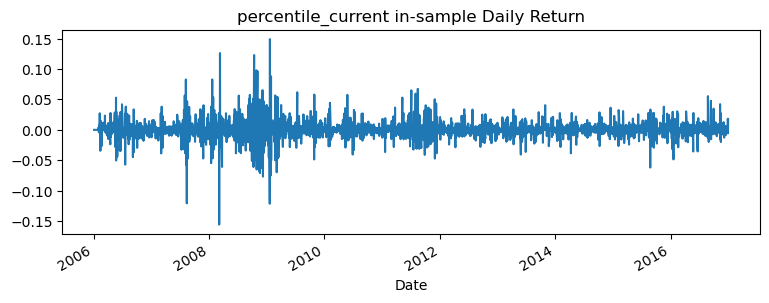

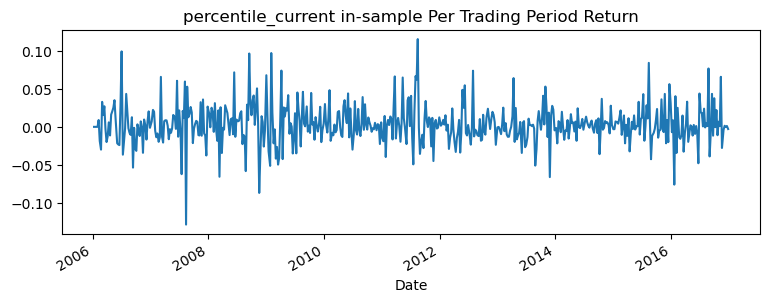

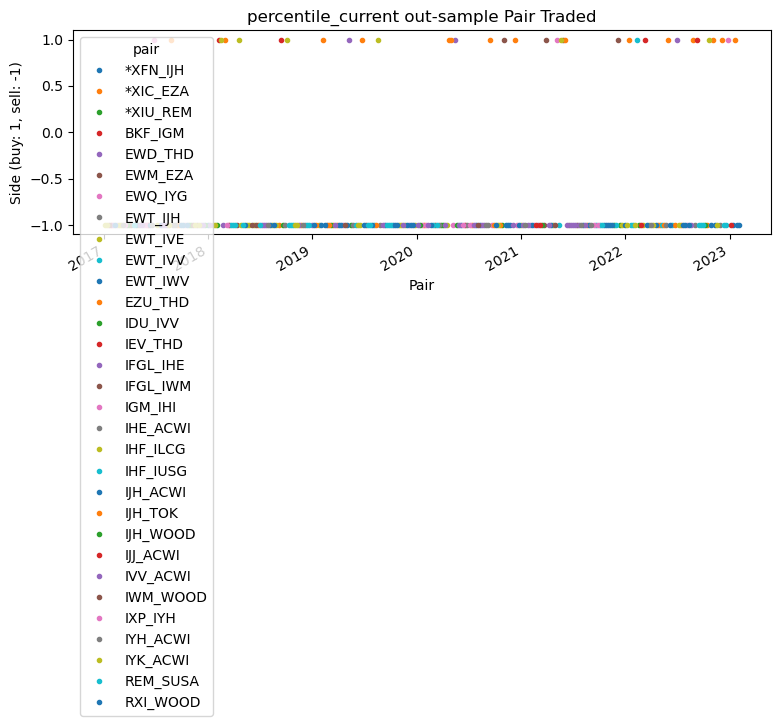

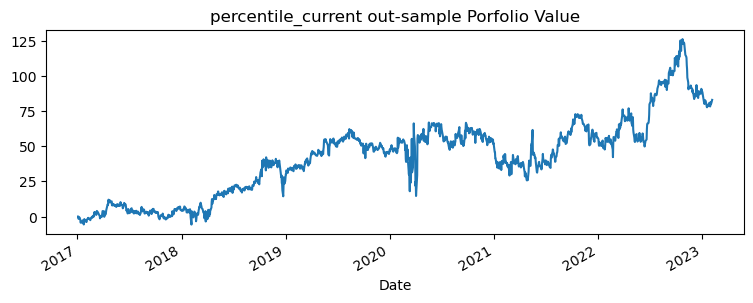

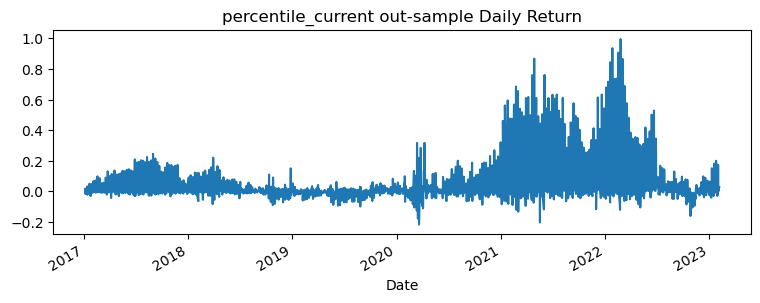

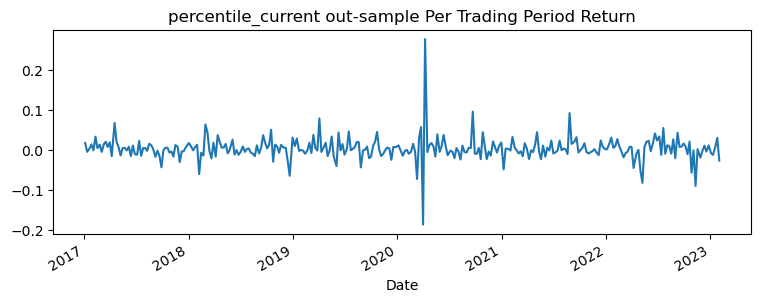

In [ ]:
pipeline.run('percentile_current', params = {
                'pred_period': 'W',
                'holding_period': 5,
                'distribution_period': 21,
                'training_period':2769,
                'periodic': False,
                'cost': 100
            }, currentMode=True)


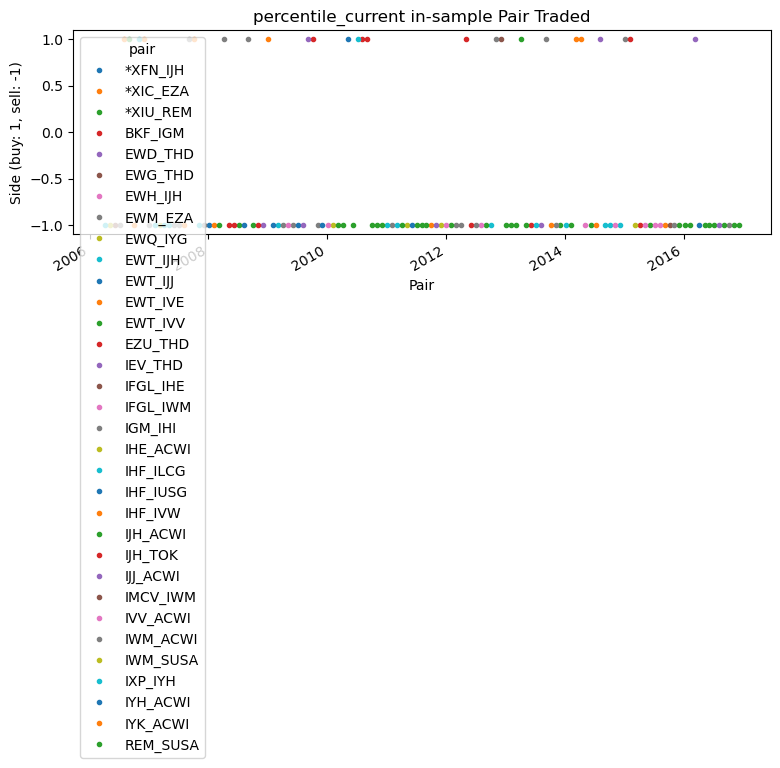

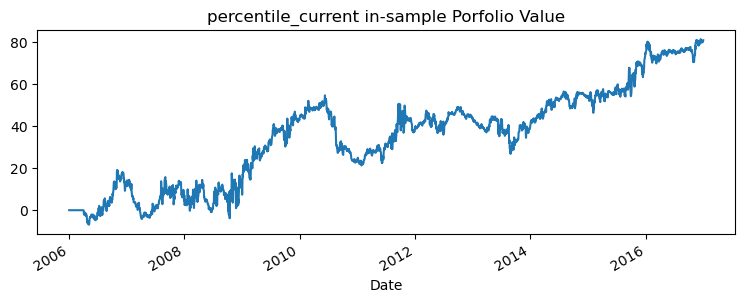

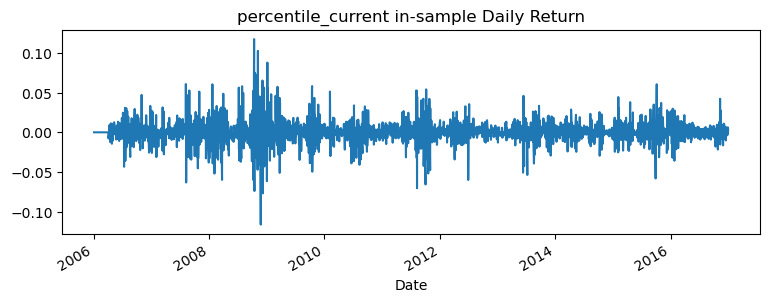

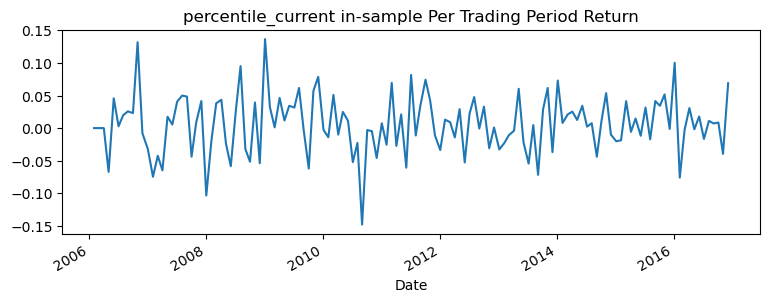

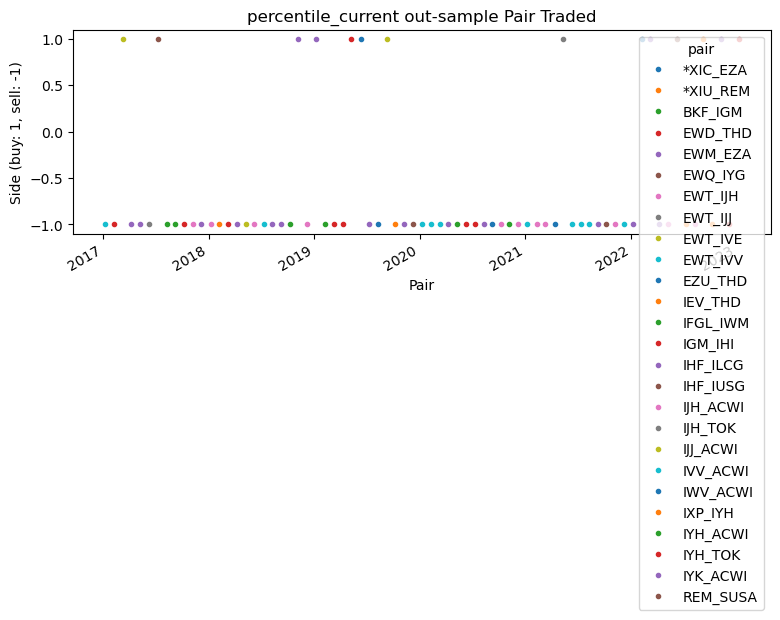

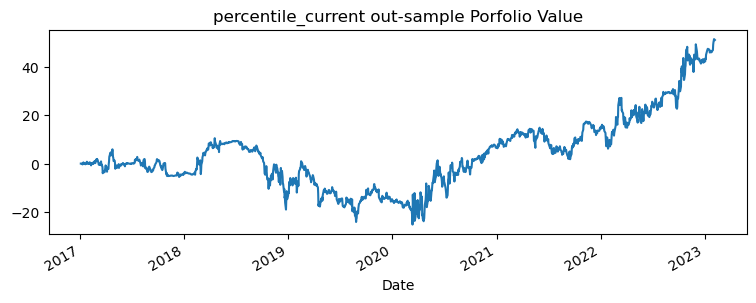

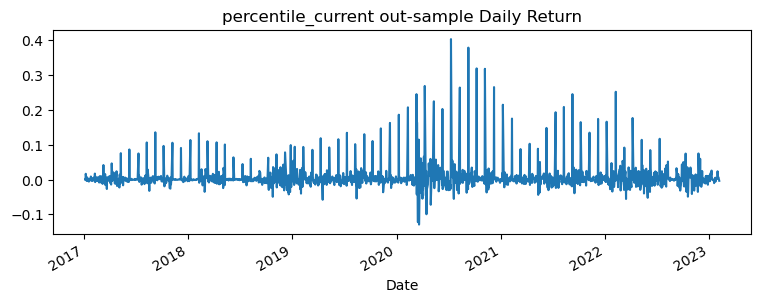

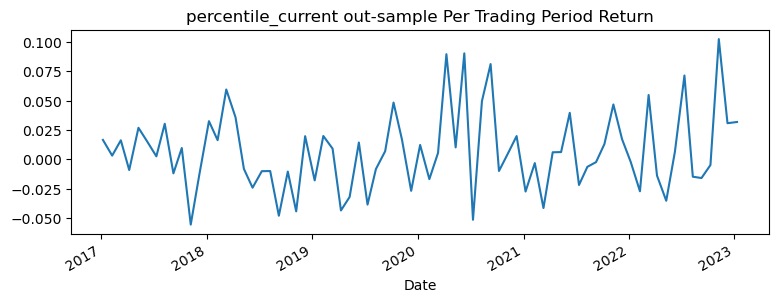

In [ ]:
pipeline.run('percentile_current', params = {
                'pred_period': 'M',
                'holding_period': 21,
                'distribution_period': 63,
                'training_period':2769,
                'periodic': False,
                'cost': 100
            }, currentMode=True)

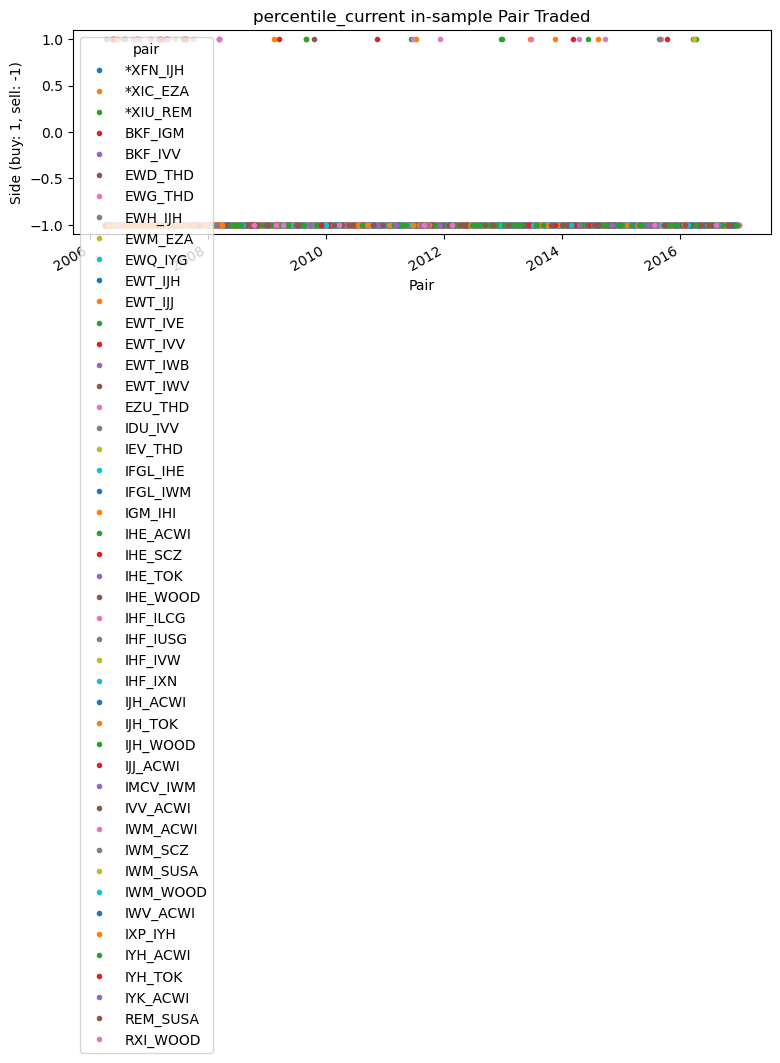

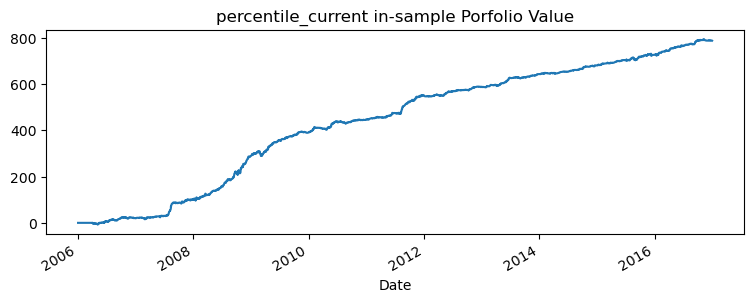

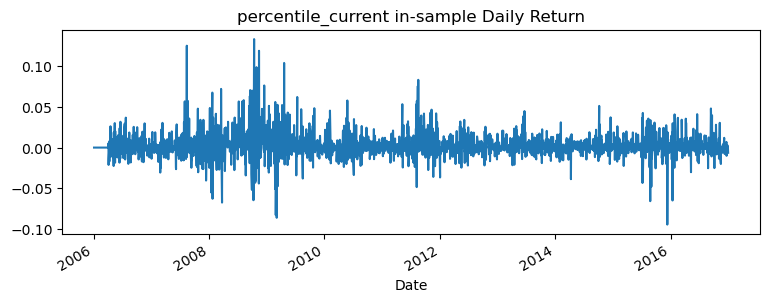

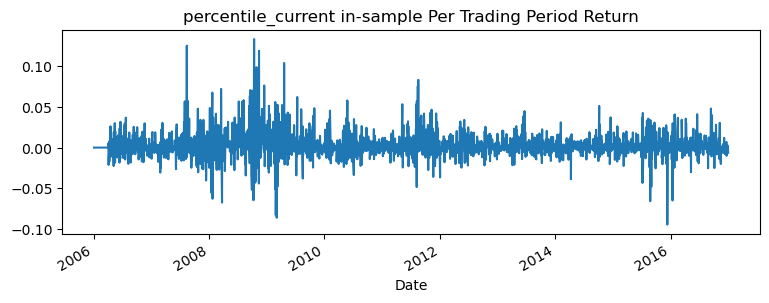

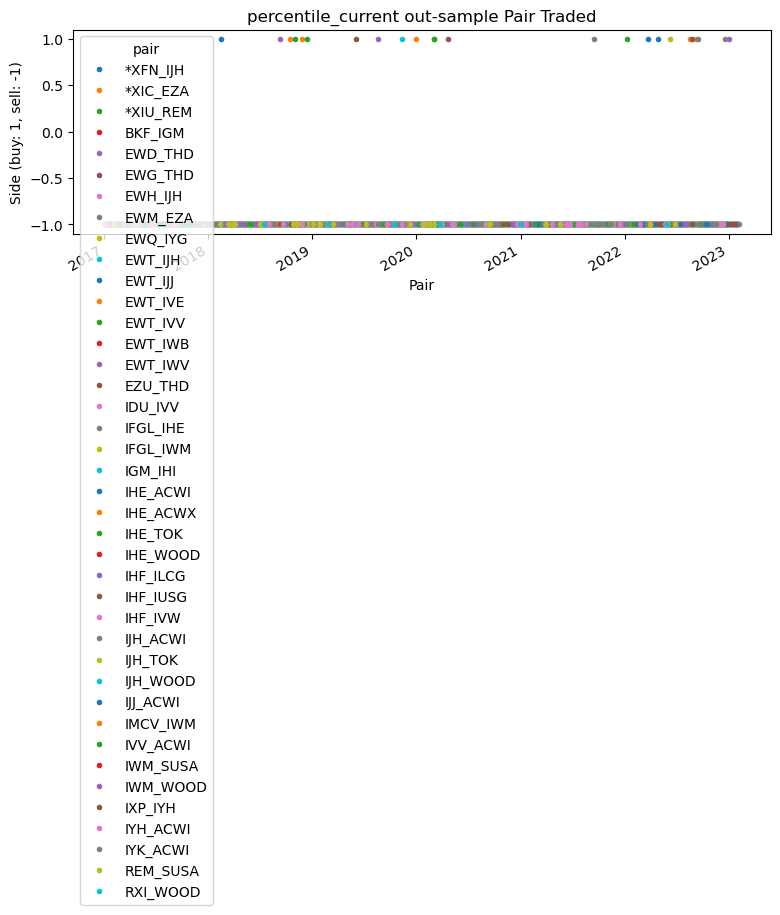

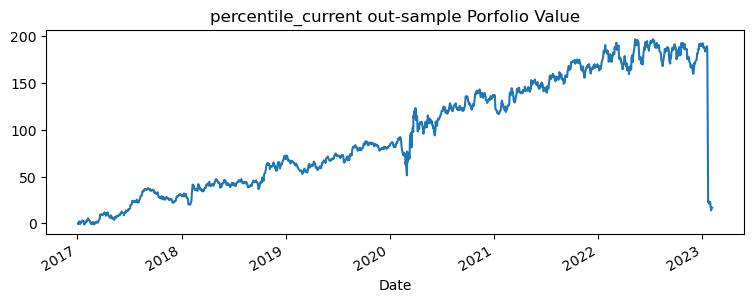

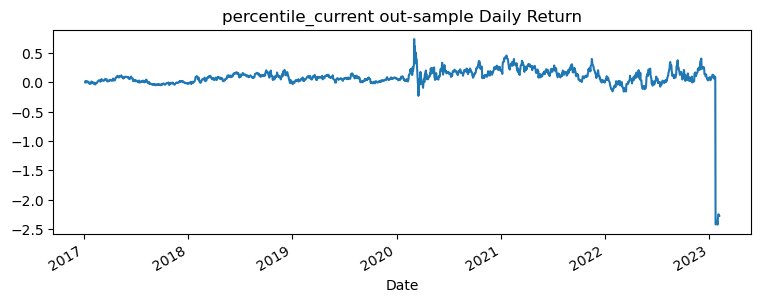

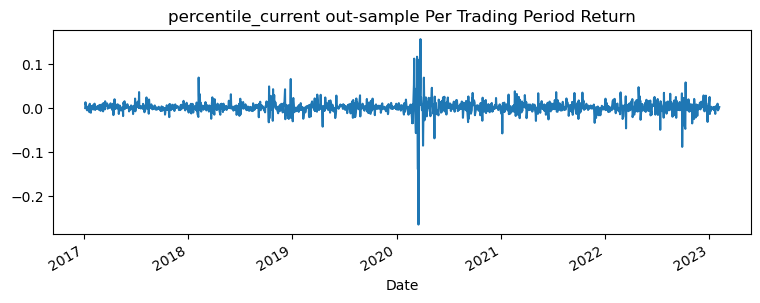

In [ ]:
pipeline.run('percentile_current', params = {
                'pred_period': 'D',
                'holding_period': 1,
                'distribution_period': 10,
                'training_period':63,
                'periodic': True,
                'cost': 100
            }, periodic=True, currentMode=True)

In [171]:
# pipeline.run('percentile_current', params = {
#                 'pred_period': 'W',
#                 'holding_period': 5,
#                 'distribution_period': 21,
#                 'training_period':63,
#                 'periodic': True,
#                 'cost': 100
#             }, periodic=True, currentMode=True)

In [173]:
# pipeline.run('percentile_current', params = {
#                 'pred_period': 'M',
#                 'holding_period': 21,
#                 'distribution_period': 63,
#                 'training_period':84,
#                 'periodic': True,
#                 'cost': 100
#             }, periodic=True, currentMode=True)

In [174]:
def ret_sum(reg_df, name):
    nav_df, result_df = performance_for_df(reg_df, rf=0.0)
    print('--------------------------------')
    print(name)
    print(result_df)
    NAV_df_plot(nav_df, nav_df.columns.tolist(), nav_df.columns.tolist(),
                labels=nav_df.columns.tolist(), fig_path=name+".jpg")

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
D in sample daily return
                       linear_periodic     elastic  elastic_periodic  \
Simple Return                18.141518  442.148977          6.819063   
Annualized Return             0.308186    0.741230          0.205824   
Annualized Volatility         0.343829    0.296164          0.279594   
Sharpe Ratio                  0.896337    2.502767          0.736152   
Adjusted Sharpe Ratio         0.610866   -4.248290          0.535142   
Sortino Ratio                 1.191742    3.583880          1.019859   
Maximum Drawdown              0.000000    0.000000          0.000000   
Calmar Ratio                       inf         inf               inf   

                                XGB  
Simple Return          2.587251e+11  
Annualized Return      9.930874e+00  
Annualized Volatility  3.633669e-01  
Sharpe Ratio           2.733015e+01  
Adjusted Sharpe Ratio -4.808785e+04  
Sortino Ratio          6.734046e+01  
Maximum Drawdown       0.00

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
D in sample period return
                       linear_periodic     elastic  elastic_periodic  \
Simple Return                18.141518  442.148977          6.819063   
Annualized Return             0.309205    0.744030          0.206478   
Annualized Volatility         0.344325    0.306414          0.291908   
Sharpe Ratio                  0.898003    2.428188          0.707339   
Adjusted Sharpe Ratio         0.612204   -1.335242          0.569588   
Sortino Ratio                 1.195681    3.748027          1.034833   
Maximum Drawdown              0.000000    0.000000          0.000000   
Calmar Ratio                       inf         inf               inf   

                                XGB  
Simple Return          2.587251e+11  
Annualized Return      1.000688e+01  
Annualized Volatility  3.808617e-01  
Sharpe Ratio           2.627432e+01  
Adjusted Sharpe Ratio -3.889166e+04  
Sortino Ratio          6.713379e+01  
Maximum Drawdown       0.0

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
D out sample daily return
                       linear_periodic   elastic  elastic_periodic        XGB
Simple Return                -0.230292  2.912165          0.271685  18.694816
Annualized Return            -0.042087  0.251181          0.040272   0.631667
Annualized Volatility         0.347404  0.303711          0.204726   0.310713
Sharpe Ratio                 -0.121147  0.827041          0.196713   2.032957
Adjusted Sharpe Ratio        -0.121703  0.370064          0.196197 -11.414952
Sortino Ratio                -0.141589  1.153160          0.276448   2.262998
Maximum Drawdown              0.000000  0.000000          0.000000   0.000000
Calmar Ratio                      -inf       inf               inf        inf


/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
D out sample period return
                       linear_periodic   elastic  elastic_periodic        XGB
Simple Return                -0.230292       NaN               NaN  18.694816
Annualized Return            -0.042114       NaN               NaN   0.632188
Annualized Volatility         0.347518  0.315336          0.212197   0.310814
Sharpe Ratio                 -0.121185       NaN               NaN   2.033978
Adjusted Sharpe Ratio        -0.121741       NaN               NaN -11.424424
Sortino Ratio                -0.141680       NaN               NaN   2.264865
Maximum Drawdown              0.000000  0.000000          0.000000   0.000000
Calmar Ratio                      -inf       NaN               NaN        inf


/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
W in sample daily return
                          linear  linear_periodic     elastic  \
Simple Return          23.535354         9.252835  702.243178   
Annualized Return       0.338079         0.235932    0.815968   
Annualized Volatility   0.249254         0.336854    0.337563   
Sharpe Ratio            1.356363         0.700396    2.417235   
Adjusted Sharpe Ratio   0.720841         0.573928    1.829303   
Sortino Ratio           1.841623         0.895413    3.752816   
Maximum Drawdown        0.000000         0.000000    0.000000   
Calmar Ratio                 inf              inf         inf   

                       elastic_periodic           XGB       lstm  
Simple Return                757.252053  1.195212e+06  -1.000000  
Annualized Return              0.828458  2.573498e+00  -0.898630  
Annualized Volatility          0.332257  3.439542e-01   0.436698  
Sharpe Ratio                   2.493422  7.482096e+00  -2.057784  
Adjusted Sharpe Ratio

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
W in sample period return
                          linear  linear_periodic   elastic  elastic_periodic  \
Simple Return          23.535354         9.252835       NaN               NaN   
Annualized Return       3.287261         1.882745       NaN               NaN   
Annualized Volatility   0.527550         0.637287  0.742325          0.760236   
Sharpe Ratio            6.231180         2.954311       NaN               NaN   
Adjusted Sharpe Ratio -21.955471        -4.965388       NaN               NaN   
Sortino Ratio           9.839211         4.090426       NaN               NaN   
Maximum Drawdown        0.000000         0.000000  0.000000          0.000000   
Calmar Ratio                 inf              inf       NaN               NaN   

                           XGB  lstm  
Simple Return              NaN   NaN  
Annualized Return          NaN   NaN  
Annualized Volatility  0.88156   NaN  
Sharpe Ratio               NaN   NaN  
Adjusted Sharpe 

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
W out sample daily return
                         linear  linear_periodic   elastic  elastic_periodic  \
Simple Return         -0.227821         8.037065  9.364905          8.817191   
Annualized Return     -0.041583         0.435664  0.468363          0.455325   
Annualized Volatility  0.276785         0.370197  0.344480          0.332893   
Sharpe Ratio          -0.150234         1.176844  1.359624          1.367781   
Adjusted Sharpe Ratio -0.144971        -0.803238  0.434096         -0.338416   
Sortino Ratio         -0.182389         1.578225  1.832185          1.795819   
Maximum Drawdown       0.000000         0.000000  0.000000          0.000000   
Calmar Ratio               -inf              inf       inf               inf   

                            XGB      lstm  
Simple Return          4.757892 -0.999999  
Annualized Return      0.333194 -0.902308  
Annualized Volatility  0.333065  0.341823  
Sharpe Ratio           1.000388 -2.639692  


/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
W out sample period return
                         linear  linear_periodic   elastic  elastic_periodic  \
Simple Return         -0.227821         8.037065       NaN               NaN   
Annualized Return     -0.191775         5.127971       NaN               NaN   
Annualized Volatility  0.584266         0.667049  0.738191          0.686804   
Sharpe Ratio          -0.328231         7.687549       NaN               NaN   
Adjusted Sharpe Ratio -0.343731       -53.659193       NaN               NaN   
Sortino Ratio         -0.332716        15.033966       NaN               NaN   
Maximum Drawdown       0.000000         0.000000  0.000000          0.000000   
Calmar Ratio               -inf              inf       NaN               NaN   

                              XGB      lstm  
Simple Return            5.125539 -0.999999  
Annualized Return        3.448735 -0.999991  
Annualized Volatility    0.696488  0.575059  
Sharpe Ratio             4.951606 -

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
M in sample daily return
                         linear  linear_periodic    elastic  elastic_periodic  \
Simple Return          1.850819         1.148738  10.165941          2.225767   
Annualized Return      0.100033         0.072090   0.245565          0.112473   
Annualized Volatility  0.206570         0.322959   0.301298          0.259239   
Sharpe Ratio           0.484257         0.223217   0.815024          0.433858   
Adjusted Sharpe Ratio  0.441544         0.217053   0.647216          0.425903   
Sortino Ratio          0.652608         0.272841   1.037617          0.601518   
Maximum Drawdown       0.000000         0.000000   0.000000          0.000000   
Calmar Ratio                inf              inf        inf               inf   

                             XGB  
Simple Return          22.603098  
Annualized Return       0.333370  
Annualized Volatility   0.330803  
Sharpe Ratio            1.007759  
Adjusted Sharpe Ratio   0.206943  
So

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
M in sample period return
                          linear  linear_periodic   elastic  elastic_periodic  \
Simple Return           1.850819              NaN  0.208030          0.142214   
Annualized Return       6.388879              NaN  0.434479          0.288976   
Annualized Volatility   0.973509              NaN  1.377477          0.398101   
Sharpe Ratio            6.562735              NaN  0.315416          0.725886   
Adjusted Sharpe Ratio -16.540513              NaN  0.345397          0.718203   
Sortino Ratio          11.603315              NaN       NaN               NaN   
Maximum Drawdown        0.000000              0.0  0.000000          0.000000   
Calmar Ratio                 inf              NaN       inf               inf   

                            XGB  
Simple Return         -0.015677  
Annualized Return     -0.029715  
Annualized Volatility  0.627041  
Sharpe Ratio          -0.047389  
Adjusted Sharpe Ratio -0.047917  
Sortino

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
M out sample daily return
                         linear  linear_periodic   elastic  elastic_periodic  \
Simple Return         -0.417509         2.664557  0.138266         -0.046219   
Annualized Return     -0.084955         0.237814  0.021503         -0.007744   
Annualized Volatility  0.243431         0.295691  0.177721          0.182748   
Sharpe Ratio          -0.348989         0.804265  0.120991         -0.042373   
Adjusted Sharpe Ratio -0.305495         0.370940  0.121155         -0.042315   
Sortino Ratio         -0.426676         1.461626  0.178416         -0.064123   
Maximum Drawdown       0.000000         0.000000  0.000000          0.000000   
Calmar Ratio               -inf              inf       inf              -inf   

                            XGB  
Simple Return          2.164249  
Annualized Return      0.208322  
Annualized Volatility  0.264459  
Sharpe Ratio           0.787730  
Adjusted Sharpe Ratio  0.336895  
Sortino Ratio   

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
M out sample period return
                         linear  linear_periodic   elastic  elastic_periodic  \
Simple Return         -0.417509     2.664557e+00       NaN               NaN   
Annualized Return     -0.845202     8.751833e+01       NaN               NaN   
Annualized Volatility  1.280053     1.921302e+00  0.835575          0.816893   
Sharpe Ratio          -0.660287     4.555157e+01       NaN               NaN   
Adjusted Sharpe Ratio -0.644565    -1.254751e+05       NaN               NaN   
Sortino Ratio         -0.613390     1.790157e+02       NaN               NaN   
Maximum Drawdown       0.000000     0.000000e+00  0.000000          0.000000   
Calmar Ratio               -inf              inf       NaN               NaN   

                                XGB  
Simple Return          2.111412e+00  
Annualized Return      4.931721e+01  
Annualized Volatility  1.805873e+00  
Sharpe Ratio           2.730934e+01  
Adjusted Sharpe Ratio -3.5774

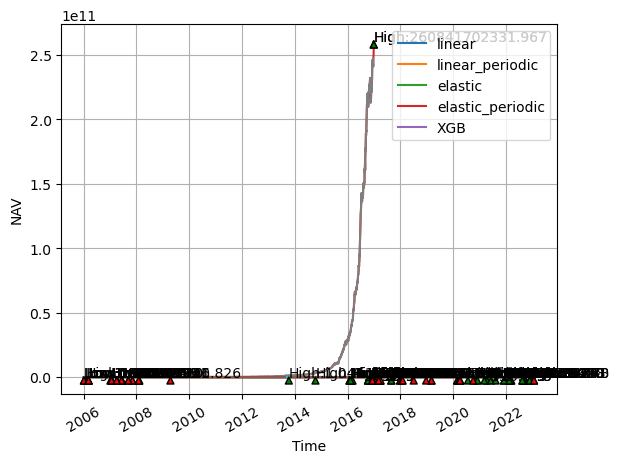

In [175]:
for p in ['D', 'W', 'M']:
    signal_res = pipeline.signal_result[p]

    in_daily_rets_df = pd.DataFrame()
    in_period_rets_df = pd.DataFrame()
    out_daily_rets_df = pd.DataFrame()
    out_period_rets_df = pd.DataFrame()
    
    for name, df in signal_res.items():
        in_daily_rets_df[name] = df[0][1]
        in_period_rets_df[name] = df[0][2]
        out_daily_rets_df[name] = df[1][1]
        out_period_rets_df[name] = df[1][2]

    ret_sum(in_daily_rets_df, f'{p} in sample daily return')
    ret_sum(in_period_rets_df, f'{p} in sample period return')
    ret_sum(out_daily_rets_df, f'{p} out sample daily return')
    ret_sum(out_period_rets_df, f'{p} out sample period return')
    
